# Magnetic Inhibition of Subsurface Convection (Jermyn & Cantiello 2020)

### Notes on the model grid:
To create ZAMS models at different composition, use `test_suite case star/test_suite/create_zams` ,
and modify the inlists accordingly (the options you want to change are in `inlist_zams_specification`). 
This will create a file with ZAMS models, which you can then copy to `$MESA_DIR/data/star_data/zams_models/"`
Once you do that, you can tell MESA to use this models by including e.g   
`initial_z = 0.014     zams_filename = 'my_ZAMS_models_name.data`
in the "controls" section of your inlist (here I assumed you named your file with ZAMS models 'my_ZAMS_models.data').

### Y and Z Values:

|GRID |Y |Z  |
| -----|:--------:|----|
|MW   |0.2659 |0.014  |
|LMC  |0.2559 |0.006  |
|SMC  |0.2508 |0.002 |

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt
import mesa_reader as mr
import numpy as np
from pylab import *
from math import log10, pi
from matplotlib import rc
#rc('mathtext', default='regular')
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec

import matplotlib.transforms as mtransforms
from matplotlib.ticker import MaxNLocator
from scipy import interpolate
from scipy.interpolate import griddata

from numpy import loadtxt
import pandas as pd 
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
 
#from Constants import Constants
#c=Constants() 

# Define some colors
BLACK      = (0.00,0.00,0.00)
ORANGE     = (0.90,0.60,0.00)
SKY_BLUE   = (0.35,0.70,0.90)
BLUE_GREEN = (0.00,0.60,0.50)
YELLOW     = (0.95,0.90,0.25)
BLUE       = (0.00,0.45,0.70)
VERMILLION = (0.80,0.40,0.00)
RED_PURPLE = (0.80,0.60,0.70)

In [2]:
####################################################
# Plt Options from Perna, Lazzati & Cantiello 2017 #
####################################################
plt.rcParams['figure.figsize'] = (6,7)
plt.rcParams['font.family'] = ['Times New Roman']
#plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlepad'] = 20 
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 16
plt.rcParams['legend.borderpad'] = 0.2
#plt.rc('legend', borderpad=0.2, markerscale=15., fancybox=False)
plt.rc('legend', borderpad=0.2, markerscale=1.0, fancybox=False)
plt.rcParams['legend.labelspacing'] = 0.5
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.handlelength'] = 1
plt.rcParams["legend.framealpha"] = 1.0
####################################################

In [3]:
## Some useful constants 
rsun=6.9598e10
msun=1.9892e33
lsun=3.8418e33
tsun = 5777
G=6.67428e-8 

In [4]:
## Some useful functions 
def find_zams(logl,loglh,model):
    zams=1
    while (loglh[zams] < 1.0*logl[zams]): 
     zams=zams+1
    return zams; 

def find_h(dh,center_h1,model):
    zams=1
    while (center_h1[zams] > (center_h1[1] - dh)): 
     zams=zams+1
    return zams; 
    
def find_tams(center_h1,model):
    tams=1
    while (center_h1[tams] > 0.05): 
     tams=tams+1
    return tams;    

def find_max(a,b,c,d):
    z= [0] * len(a)
    for i in range(0, len(a)):
      z[i]=max(a[i],b[i],c[i],d[i])   
    return z;

def binary(z):  
    for i in range(0, len(z)):
      if z[i] > 0:
         z[i] = 1
      else: 
         z[i] = 0
    return z;

def pbeta(p,b):    # Plasma Beta
    beta= 8*3.1415*p/(b**2.0)
    return beta;

def rossby(vcon,vroteq,hp,req): # Rossby number, defined as Prot/Pcon
    ross =(3.14*req/hp)*(vcon/veq)
    return ross; 
def beq(vcon,rho): # Calculate equipartition Bfield
    b=vcon*(4*3.14*rho)**0.5
    return b;

def beq(vcon,rho): # Calculate equipartition Bfield
    b=vcon*(4*3.14*rho)**0.5
    return b;

def beq_omega(vcon,rho,hp,omega): # Calculate rotating equipartition field (See eq.15 in JC20)
    b=vcon*(4*3.14*rho)**0.5
    b=b*(1+(omega*hp/vcon))**0.5
    return b;

# Find middle of main sequence (in age)

def find_mid_ms(model,star_age,zams,tams):
    mid_ms=1
    age_ms=(star_age[tams]-star_age[zams])/2
    while (star_age[mid_ms] < age_ms): 
     mid_ms=mid_ms+1
    return mid_ms;  

def find_frac_ms(model,star_age,zams,tams,frac):
    frac_ms=1
    age_frac_ms=(star_age[tams]-star_age[zams])*frac
    while ((star_age[frac_ms] - star_age[zams]) < age_frac_ms): 
     frac_ms=frac_ms+1
    return frac_ms;    

## Profile of Relevant Quantities in the CZs 

In [10]:
# Data Location (You'll need to adapt this to your local path)
FIGURES='./figures/' # place to save output
DIR = './' # adapt this to the directory where you unpacked the data
# Read Data
h=mr.MesaData(DIR+'2.4/LOGS/history.data')
p=mr.MesaData(DIR+'2.4/LOGS/profile10.data')

In [11]:
# Extract Data columns
logt=np.log10(p.temperature)
kappa=p.opacity
hp=p.pressure_scale_height*rsun # cm/s
r=p.radius
mass=p.mass
dq=p.dq
pressure=p.pressure
luminosity=p.luminosity
mlt_mixing_length=p.mlt_mixing_length
mixing_type=p.mixing_type
grada=p.grada
gradr=p.gradr
superad=p.super_ad
req= (max(r))*rsun #cm/s
#gradr=p.gradr
pressure=p.pressure
rho=p.logRho
age=p.star_age
tau=p.log_tau
mach=p.conv_vel_div_csound
vcon=10**(p.log_conv_vel)
B_shutoff=p.B_shutoff 
radius=p.radius

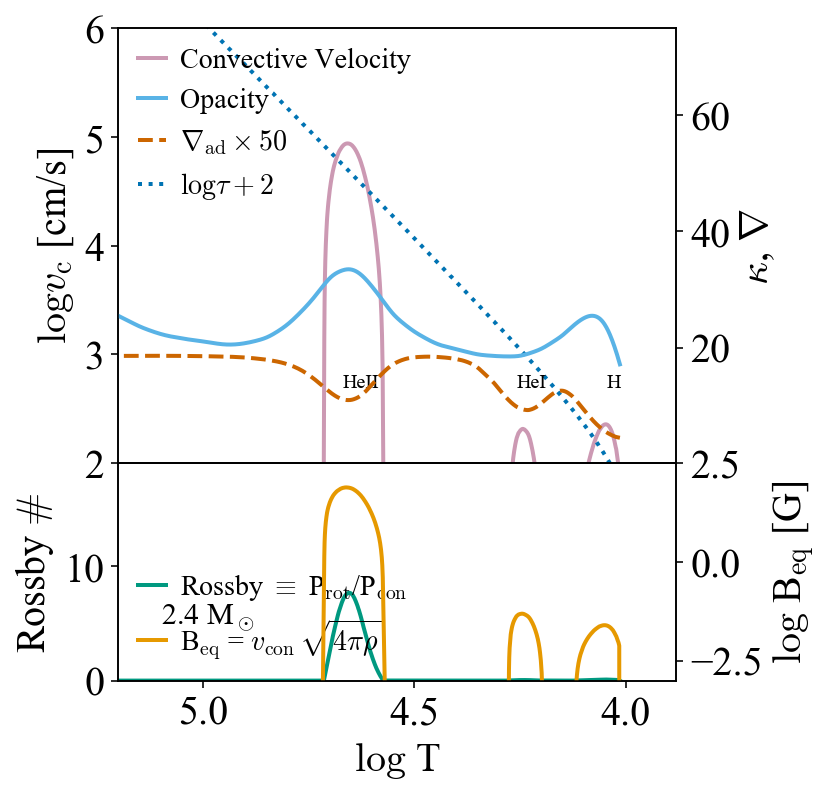

In [12]:
# Set Rotational Velocity (for calculating Rossby Number and Beq,omega):
veq = 150e5 # km/s

plt.rcParams['figure.figsize'] = (5,6)
xylim=[5.2,3.88]
lw=2
gs1 = gridspec.GridSpec(2, 1,height_ratios=[2,1])
# No space between plots, e.g.: gs1.update(left=0.1, right=0.9, wspace=0.00,hspace=0.00)
gs1.update(wspace=0.00,hspace=0.00)
# Assign axis and remove xticks from top plot
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[1,0])
#ax3 = plt.subplot(gs1[2,0])
ax1.set_xticks([])
#ax2.set_xticks([])


lns1=ax1.plot(logt,np.log10(vcon),c=RED_PURPLE,label='Convective Velocity',lw=lw)

ax1b = ax1.twinx()
lns1b=ax1b.plot(logt,kappa,c=SKY_BLUE,label='Opacity',lw=lw)#,label='Convective Velocity (cm/s)')
lns1a=ax1b.plot(logt,grada*50,c=VERMILLION,label=r'$\nabla_{\rm ad} \times 50$',lw=lw,ls='--',zorder=1)
lns3=ax1.plot(logt,tau+2,c=BLUE,label=r'$\log \tau + 2$ ',lw=lw,ls=':')


#lns3=ax1.plot(logt,mach*100,c=BLUE,label=r'Mach \# $\times$ 100',lw=lw,ls=':')
#lns1c=ax1b.plot(logt,superad*100,c=BLUE,label=r'$(\nabla - \nabla_{\rm ad}) \times 100$',lw=lw,ls=':')
ax1.set_ylim(2,6)
ax1b.set_ylim(0.1,75)

ax1.set_ylabel(r'$\log v_{\rm c}$ [cm/s]')
ax1b.set_ylabel(r'$\kappa$, $\nabla$')
#legend = ax1.legend(loc='upper right')#,fontsize=10) #,prop={'size':12})



#legend = ax1.legend(loc='upper left',fontsize=6) #,prop={'size':12})

lns2=ax2.plot(logt,rossby(vcon,veq,hp,req),c=BLUE_GREEN,label=r'Rossby $\equiv$ P$_{\rm rot}$/P$_{\rm con}$',lw=lw)#,label='H$_{\rm P}$ [R$_\odot$]')

ax2.set_ylim(0,19)
ax2b = ax2.twinx()
lns2b=ax2b.plot(logt,np.log10(beq(vcon,10**rho)),c=ORANGE,label=r'B$_{\rm eq}$ = $v_{\rm con}\,\sqrt{4\pi\rho}$',lw=lw)# = P$_{\rm rot}$/P$_{\rm con}$')#,label='H$_{\rm P}$ [R$_\odot$]')
ax2b.set_ylim(-3,2.5)

#legend = ax2.legend(loc='upper right')#,fontsize=10) #,prop={'size':12})

# added these three lines
lns = lns1+lns1b+lns1a + lns3 
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')
lns_low = lns2 + lns2b
labs2 = [l.get_label() for l in lns_low]
ax2.legend(lns_low, labs2, loc='lower left')

#ax2.set_ylabel(r'$\log \, [dt/{\rm yr}]$')

#ax3.scatter(model,num_newton_iterations,c=BLUE,s=5)
#ax3.set_ylabel('Iterations')

ax2.set_xlabel(r'$\log$ T')
ax2.set_ylabel(r'Rossby $\#$')#(P$_{\rm rot}$/P$_{\rm c}$)')
ax2b.set_ylabel(r'$\log$ B$_{\rm eq}$ [G]')#(P$_{\rm rot}$/P$_{\rm c}$)')


ax1.set_xlim(xylim)
ax2.set_xlim(xylim)
ax1b.set_xlim(xylim)
ax2b.set_xlim(xylim)
fs=10
ax1.annotate('HeII',(4.67,2.7), fontsize=fs)
ax1.annotate('HeI',(4.258,2.7), fontsize=fs)
ax1.annotate('H',(4.045,2.7), fontsize=fs)
ax2.annotate(r'2.4 M$_\odot$',(5.1,5), fontsize=fs+5)




plt.savefig(FIGURES+"profiles.pdf")

## For 2.4 Msun Star

In [13]:
MASS = '2.4'
h=mr.MesaData(DIR+MASS+'/LOGS/history.data')
p=mr.MesaData(DIR+MASS+'/LOGS/profile10.data')

logt=np.log10(p.temperature)
kappa=p.opacity
hp=p.pressure_scale_height*rsun # cm/s
r=p.radius
mass=p.mass
dq=p.dq
pressure=p.pressure
luminosity=p.luminosity
mlt_mixing_length=p.mlt_mixing_length
mixing_type=p.mixing_type
grada=p.grada
gradr=p.gradr
mach=p.conv_vel_div_csound
superad=p.super_ad
req= (max(r))*rsun #cm/s
#gradr=p.gradr
pressure=p.pressure
rho=p.logRho
age=p.star_age
tau=p.log_tau
mach=p.conv_vel_div_csound
vcon=10**(p.log_conv_vel)
B_shutoff=p.B_shutoff 
radius=p.radius

logt2=np.log10(p.Teff)
logl2=np.log10(p.photosphere_L)
data2=[logt2,logl2]
print(data2)
# Set Rotational Velocity (for calculating Rossby Number and Beq,omega):
veq = 150e5 # km/s

[4.01263775392682, 1.5274725254505748]


/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10


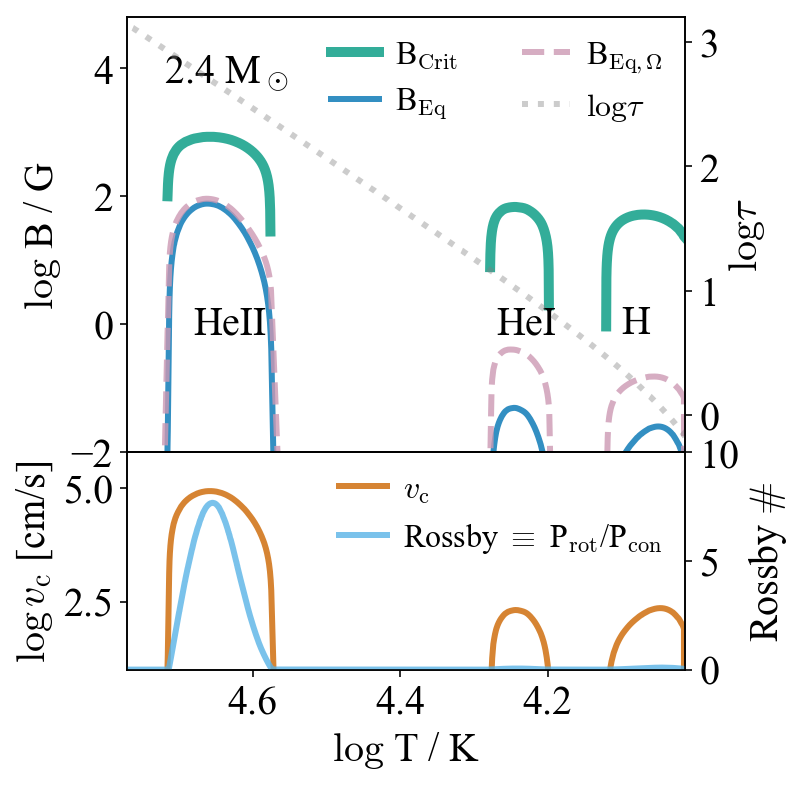

In [14]:

plt.rcParams['figure.figsize'] = (5,6)
mint=np.min(logt)
xylim=[4.77,mint]
lw=3
alpha = 0.8
gs1 = gridspec.GridSpec(2, 1,height_ratios=[2,1])
# No space between plots, e.g.: gs1.update(left=0.1, right=0.9, wspace=0.00,hspace=0.00)
gs1.update(wspace=0.00,hspace=0.00)

# Assign axis and remove xticks from top plot
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[1,0])
#ax3 = plt.subplot(gs1[2,0])
ax1.set_xticks([])

# Magnetic Fields

omega=veq/(radius[1]*rsun)
b=beq_omega(vcon,10**rho,hp,omega)

lns_bshutoff=ax1.plot(logt,np.log10(B_shutoff),c=BLUE_GREEN,label=r'B$_{\rm Crit}$',lw=lw+2,ls='-',alpha=alpha)
lns_beq=ax1.plot(logt,np.log10(beq(vcon,10**rho)),c=BLUE,label=r'B$_{\rm Eq}$',lw=lw,ls='-',alpha=alpha)#,label='Convective Velocity (cm/s)')
lns_beq_rot=ax1.plot(logt,np.log10(beq_omega(vcon,10**rho,hp,omega)),c=RED_PURPLE,label=r'B$_{\rm Eq, \Omega}$',lw=lw,ls='--',alpha=alpha)

ax1b = ax1.twinx()

lns_tau=ax1b.plot(logt,tau,c='gray',label=r'$\log \tau$ ',lw=lw,ls=':',alpha=alpha-0.4)

ax1b.set_ylim(-0.3,3.2)
ax1.set_ylim(-2,4.8)

ax1b.set_ylabel(r'$\log \tau$')
ax1.set_ylabel(r'$\log $ B / G')


lns2_vcon=ax2.plot(logt,np.log10(vcon),c=VERMILLION,label=r'$v_{\rm c}$',lw=lw,alpha=alpha)

ax2.set_ylim(1,5.8)
ax2b = ax2.twinx()

lns2_rossby=ax2b.plot(logt,rossby(vcon,veq,hp,req),c=SKY_BLUE,label=r'Rossby $\equiv$ P$_{\rm rot}$/P$_{\rm con}$',lw=lw,alpha=alpha)#,label='H$_{\rm P}$ [R$_\odot$]')
ax2b.set_ylim(0,10)

# Take care of legends
lns = lns_bshutoff+lns_beq +lns_beq_rot +lns_tau
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right',handlelength=1.5,fontsize=16,ncol=2)
lns_low = lns2_vcon + lns2_rossby
labs2 = [l.get_label() for l in lns_low]
ax2.legend(lns_low, labs2, loc='upper right',handlelength=1.5,fontsize=16)


ax2.set_xlabel(r'$\log$ T / K')
ax2b.set_ylabel(r'Rossby $\#$')#(P$_{\rm rot}$/P$_{\rm c}$)')
ax2.set_ylabel(r'$\log \, v_{\rm c}$ [cm/s]')#(P$_{\rm rot}$/P$_{\rm c}$)')

ax1.set_xlim(xylim)
ax2.set_xlim(xylim)
ax1b.set_xlim(xylim)
ax2b.set_xlim(xylim)
fs=15
ax1.annotate('HeII',(4.68,-0.15), fontsize=fs+5)
ax1.annotate('HeI',(4.27,-0.15), fontsize=fs+5)
ax1.annotate('H',(4.1,-0.15), fontsize=fs+5)
ax1.annotate(MASS+r' M$_\odot$',(4.72,3.8), fontsize=fs+5)



plt.savefig(FIGURES+MASS+"_b_shutoff_profile.pdf",bbox_inches='tight')



### Testing Plot

/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10


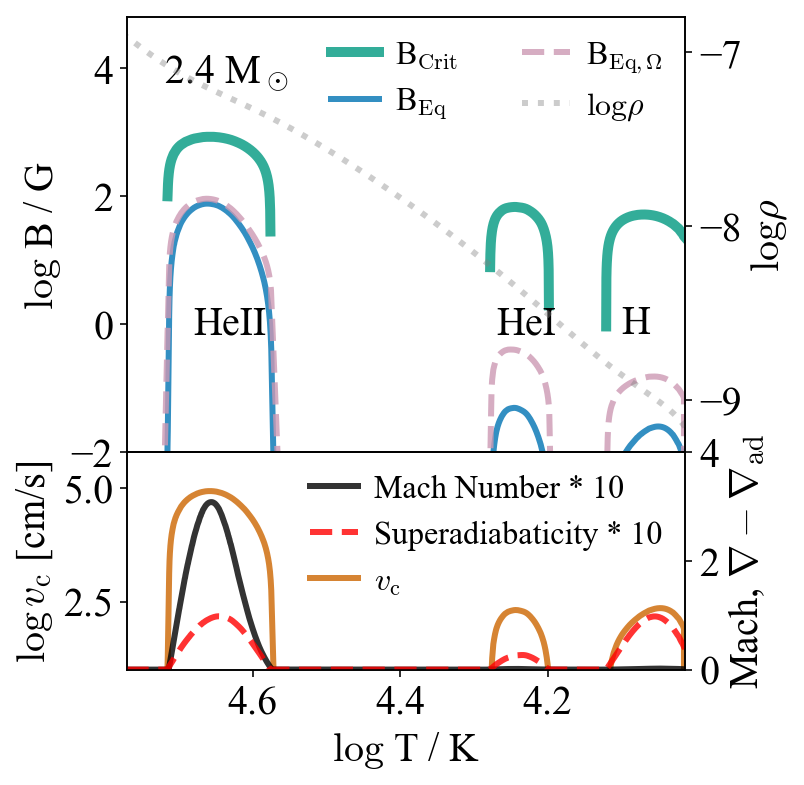

In [15]:

plt.rcParams['figure.figsize'] = (5,6)
mint=np.min(logt)
xylim=[4.77,mint]
lw=3
alpha = 0.8
gs1 = gridspec.GridSpec(2, 1,height_ratios=[2,1])
# No space between plots, e.g.: gs1.update(left=0.1, right=0.9, wspace=0.00,hspace=0.00)
gs1.update(wspace=0.00,hspace=0.00)

# Assign axis and remove xticks from top plot
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[1,0])
#ax3 = plt.subplot(gs1[2,0])
ax1.set_xticks([])

# Magnetic Fields

omega=veq/(radius[1]*rsun)
b=beq_omega(vcon,10**rho,hp,omega)

lns_bshutoff=ax1.plot(logt,np.log10(B_shutoff),c=BLUE_GREEN,label=r'B$_{\rm Crit}$',lw=lw+2,ls='-',alpha=alpha)
lns_beq=ax1.plot(logt,np.log10(beq(vcon,10**rho)),c=BLUE,label=r'B$_{\rm Eq}$',lw=lw,ls='-',alpha=alpha)#,label='Convective Velocity (cm/s)')
lns_beq_rot=ax1.plot(logt,np.log10(beq_omega(vcon,10**rho,hp,omega)),c=RED_PURPLE,label=r'B$_{\rm Eq, \Omega}$',lw=lw,ls='--',alpha=alpha)

ax1b = ax1.twinx()

lns_tau=ax1b.plot(logt,rho,c='gray',label=r'$\log \rho$ ',lw=lw,ls=':',alpha=alpha-0.4)

ax1b.set_ylim(-9.3,-6.8)
ax1.set_ylim(-2,4.8)

ax1b.set_ylabel(r'$\log \rho$')
ax1.set_ylabel(r'$\log $ B / G')


lns2_vcon=ax2.plot(logt,np.log10(vcon),c=VERMILLION,label=r'$v_{\rm c}$',lw=lw,alpha=alpha)

ax2.set_ylim(1,5.8)
ax2b = ax2.twinx()




#lns2_rossby=ax2b.plot(logt,rossby(vcon,veq,hp,req),c=SKY_BLUE,label=r'Rossby $\equiv$ P$_{\rm rot}$/P$_{\rm con}$',lw=lw,alpha=alpha)#,label='H$_{\rm P}$ [R$_\odot$]')
ax2b.set_ylim(0,4)

lns2_mach=ax2b.plot(logt,mach*100,c='black',label=r'Mach Number * 10',lw=lw,alpha=alpha)
lns2_superad=ax2b.plot(logt,superad*10,c='red',label=r'Superadiabaticity * 10',ls='--',lw=lw,alpha=alpha)



# Take care of legends
lns = lns_bshutoff+lns_beq +lns_beq_rot +lns_tau
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right',handlelength=1.5,fontsize=16,ncol=2)
#lns_low = lns2_vcon + lns2_rossby
lns_low = lns2_mach + lns2_superad + lns2_vcon
labs2 = [l.get_label() for l in lns_low]
ax2.legend(lns_low, labs2, loc='upper right',handlelength=1.5,fontsize=16)


ax2.set_xlabel(r'$\log$ T / K')
ax2b.set_ylabel(r'Mach, $\nabla - \nabla_{\rm ad}$')#(P$_{\rm rot}$/P$_{\rm c}$)')
ax2.set_ylabel(r'$\log \, v_{\rm c}$ [cm/s]')#(P$_{\rm rot}$/P$_{\rm c}$)')

ax1.set_xlim(xylim)
ax2.set_xlim(xylim)
ax1b.set_xlim(xylim)
ax2b.set_xlim(xylim)
fs=15
ax1.annotate('HeII',(4.68,-0.15), fontsize=fs+5)
ax1.annotate('HeI',(4.27,-0.15), fontsize=fs+5)
ax1.annotate('H',(4.1,-0.15), fontsize=fs+5)
ax1.annotate(MASS+r' M$_\odot$',(4.72,3.8), fontsize=fs+5)



plt.savefig(FIGURES+MASS+"_b_shutoff_profile_density.pdf",bbox_inches='tight')



## Close to ther ridge

In [16]:
MASS = '2.4'
h=mr.MesaData(DIR+MASS+'/LOGS/history.data')
p=mr.MesaData(DIR+MASS+'/LOGS/profile18.data')

logt=np.log10(p.temperature)
kappa=p.opacity
hp=p.pressure_scale_height*rsun # cm/s
r=p.radius
mass=p.mass
dq=p.dq
pressure=p.pressure
luminosity=p.luminosity
mlt_mixing_length=p.mlt_mixing_length
mixing_type=p.mixing_type
grada=p.grada
gradr=p.gradr
mach=p.conv_vel_div_csound
superad=p.super_ad
req= (max(r))*rsun #cm/s
#gradr=p.gradr
pressure=p.pressure
rho=p.logRho
age=p.star_age
tau=p.log_tau
mach=p.conv_vel_div_csound
vcon=10**(p.log_conv_vel)
B_shutoff=p.B_shutoff 
radius=p.radius

logt2=np.log10(p.Teff)
logl2=np.log10(p.photosphere_L)
data2=[logt2,logl2]
print(data2)
# Set Rotational Velocity (for calculating Rossby Number and Beq,omega):
veq = 150e5 # km/s

# Find fractional age
model = h.model_number 
logl = h.log_L
logg = h.log_g 
loglh=h.log_LH 
center_h1 = h.center_h1 
zams=find_zams(logl,loglh,model)
tams=find_tams(center_h1,model)
        
print('Fractional age:', p.star_age/h.star_age[tams])

[3.9414023101459055, 1.676670432408777]
Fractional age: 0.7907489363340964


/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10


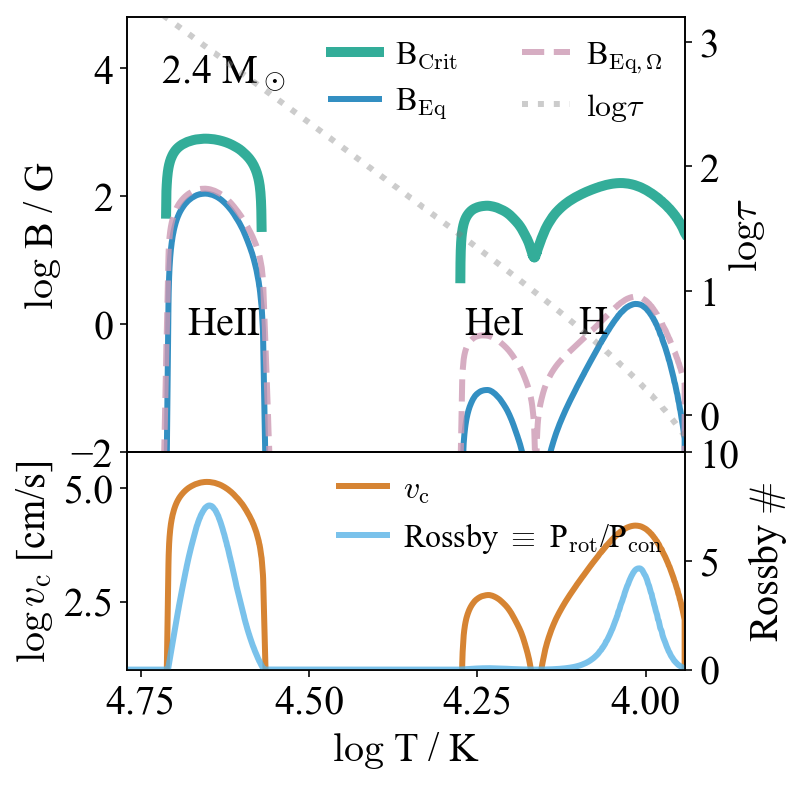

In [17]:

plt.rcParams['figure.figsize'] = (5,6)
mint=np.min(logt)
xylim=[4.77,mint]
lw=3
alpha = 0.8
gs1 = gridspec.GridSpec(2, 1,height_ratios=[2,1])
# No space between plots, e.g.: gs1.update(left=0.1, right=0.9, wspace=0.00,hspace=0.00)
gs1.update(wspace=0.00,hspace=0.00)

# Assign axis and remove xticks from top plot
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[1,0])
#ax3 = plt.subplot(gs1[2,0])
ax1.set_xticks([])

# Magnetic Fields

omega=veq/(radius[1]*rsun)
b=beq_omega(vcon,10**rho,hp,omega)

lns_bshutoff=ax1.plot(logt,np.log10(B_shutoff),c=BLUE_GREEN,label=r'B$_{\rm Crit}$',lw=lw+2,ls='-',alpha=alpha)
lns_beq=ax1.plot(logt,np.log10(beq(vcon,10**rho)),c=BLUE,label=r'B$_{\rm Eq}$',lw=lw,ls='-',alpha=alpha)#,label='Convective Velocity (cm/s)')
lns_beq_rot=ax1.plot(logt,np.log10(beq_omega(vcon,10**rho,hp,omega)),c=RED_PURPLE,label=r'B$_{\rm Eq, \Omega}$',lw=lw,ls='--',alpha=alpha)

ax1b = ax1.twinx()

lns_tau=ax1b.plot(logt,tau,c='gray',label=r'$\log \tau$ ',lw=lw,ls=':',alpha=alpha-0.4)

ax1b.set_ylim(-0.3,3.2)
ax1.set_ylim(-2,4.8)

ax1b.set_ylabel(r'$\log \tau$')
ax1.set_ylabel(r'$\log $ B / G')


lns2_vcon=ax2.plot(logt,np.log10(vcon),c=VERMILLION,label=r'$v_{\rm c}$',lw=lw,alpha=alpha)

ax2.set_ylim(1,5.8)
ax2b = ax2.twinx()

lns2_rossby=ax2b.plot(logt,rossby(vcon,veq,hp,req),c=SKY_BLUE,label=r'Rossby $\equiv$ P$_{\rm rot}$/P$_{\rm con}$',lw=lw,alpha=alpha)#,label='H$_{\rm P}$ [R$_\odot$]')
ax2b.set_ylim(0,10)

# Take care of legends
lns = lns_bshutoff+lns_beq +lns_beq_rot +lns_tau
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right',handlelength=1.5,fontsize=16,ncol=2)
lns_low = lns2_vcon + lns2_rossby
labs2 = [l.get_label() for l in lns_low]
ax2.legend(lns_low, labs2, loc='upper right',handlelength=1.5,fontsize=16)


ax2.set_xlabel(r'$\log$ T / K')
ax2b.set_ylabel(r'Rossby $\#$')#(P$_{\rm rot}$/P$_{\rm c}$)')
ax2.set_ylabel(r'$\log \, v_{\rm c}$ [cm/s]')#(P$_{\rm rot}$/P$_{\rm c}$)')

ax1.set_xlim(xylim)
ax2.set_xlim(xylim)
ax1b.set_xlim(xylim)
ax2b.set_xlim(xylim)
fs=15
ax1.annotate('HeII',(4.68,-0.15), fontsize=fs+5)
ax1.annotate('HeI',(4.27,-0.15), fontsize=fs+5)
ax1.annotate('H',(4.1,-0.15), fontsize=fs+5)
ax1.annotate(MASS+r' M$_\odot$',(4.72,3.8), fontsize=fs+5)



plt.savefig(FIGURES+MASS+"_b_shutoff_profile_ridge.pdf",bbox_inches='tight')



/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10


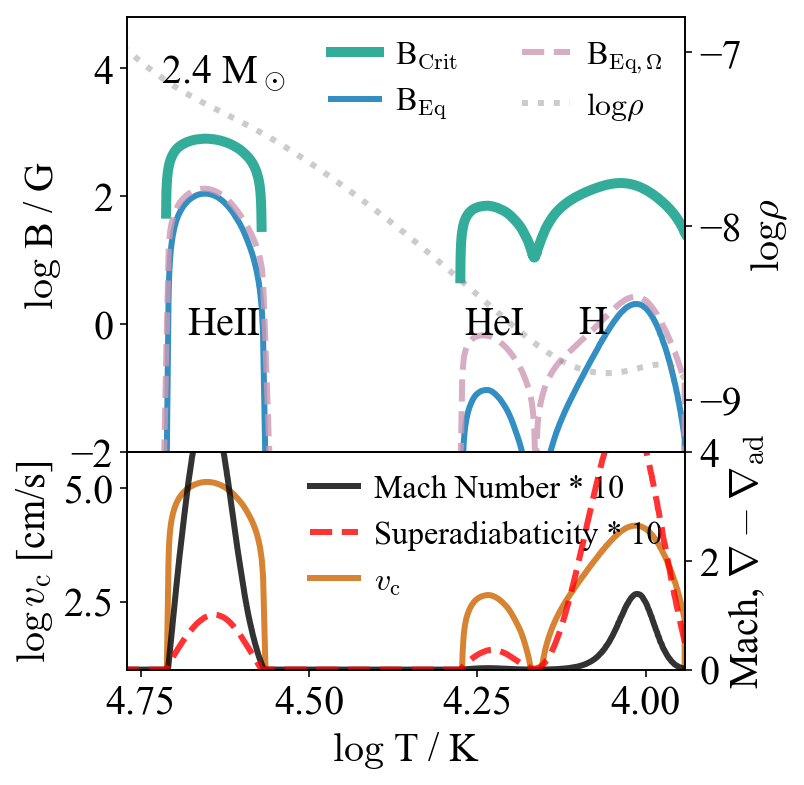

In [18]:

plt.rcParams['figure.figsize'] = (5,6)
mint=np.min(logt)
xylim=[4.77,mint]
lw=3
alpha = 0.8
gs1 = gridspec.GridSpec(2, 1,height_ratios=[2,1])
# No space between plots, e.g.: gs1.update(left=0.1, right=0.9, wspace=0.00,hspace=0.00)
gs1.update(wspace=0.00,hspace=0.00)

# Assign axis and remove xticks from top plot
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[1,0])
#ax3 = plt.subplot(gs1[2,0])
ax1.set_xticks([])

# Magnetic Fields

omega=veq/(radius[1]*rsun)
b=beq_omega(vcon,10**rho,hp,omega)

lns_bshutoff=ax1.plot(logt,np.log10(B_shutoff),c=BLUE_GREEN,label=r'B$_{\rm Crit}$',lw=lw+2,ls='-',alpha=alpha)
lns_beq=ax1.plot(logt,np.log10(beq(vcon,10**rho)),c=BLUE,label=r'B$_{\rm Eq}$',lw=lw,ls='-',alpha=alpha)#,label='Convective Velocity (cm/s)')
lns_beq_rot=ax1.plot(logt,np.log10(beq_omega(vcon,10**rho,hp,omega)),c=RED_PURPLE,label=r'B$_{\rm Eq, \Omega}$',lw=lw,ls='--',alpha=alpha)

ax1b = ax1.twinx()

lns_tau=ax1b.plot(logt,rho,c='gray',label=r'$\log \rho$ ',lw=lw,ls=':',alpha=alpha-0.4)

ax1b.set_ylim(-9.3,-6.8)
ax1.set_ylim(-2,4.8)

ax1b.set_ylabel(r'$\log \rho$')
ax1.set_ylabel(r'$\log $ B / G')


lns2_vcon=ax2.plot(logt,np.log10(vcon),c=VERMILLION,label=r'$v_{\rm c}$',lw=lw,alpha=alpha)

ax2.set_ylim(1,5.8)
ax2b = ax2.twinx()




#lns2_rossby=ax2b.plot(logt,rossby(vcon,veq,hp,req),c=SKY_BLUE,label=r'Rossby $\equiv$ P$_{\rm rot}$/P$_{\rm con}$',lw=lw,alpha=alpha)#,label='H$_{\rm P}$ [R$_\odot$]')
ax2b.set_ylim(0,4)

lns2_mach=ax2b.plot(logt,mach*100,c='black',label=r'Mach Number * 10',lw=lw,alpha=alpha)
lns2_superad=ax2b.plot(logt,superad*10,c='red',label=r'Superadiabaticity * 10',ls='--',lw=lw,alpha=alpha)



# Take care of legends
lns = lns_bshutoff+lns_beq +lns_beq_rot +lns_tau
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right',handlelength=1.5,fontsize=16,ncol=2)
#lns_low = lns2_vcon + lns2_rossby
lns_low = lns2_mach + lns2_superad + lns2_vcon
labs2 = [l.get_label() for l in lns_low]
ax2.legend(lns_low, labs2, loc='upper right',handlelength=1.5,fontsize=16)


ax2.set_xlabel(r'$\log$ T / K')
ax2b.set_ylabel(r'Mach, $\nabla - \nabla_{\rm ad}$')#(P$_{\rm rot}$/P$_{\rm c}$)')
ax2.set_ylabel(r'$\log \, v_{\rm c}$ [cm/s]')#(P$_{\rm rot}$/P$_{\rm c}$)')

ax1.set_xlim(xylim)
ax2.set_xlim(xylim)
ax1b.set_xlim(xylim)
ax2b.set_xlim(xylim)
fs=15
ax1.annotate('HeII',(4.68,-0.15), fontsize=fs+5)
ax1.annotate('HeI',(4.27,-0.15), fontsize=fs+5)
ax1.annotate('H',(4.1,-0.15), fontsize=fs+5)
ax1.annotate(MASS+r' M$_\odot$',(4.72,3.8), fontsize=fs+5)



plt.savefig(FIGURES+MASS+"_b_shutoff_profile_density_ridge.pdf",bbox_inches='tight')



## For 5Msun Star

In [19]:
MASS = '5.0'
h=mr.MesaData(DIR+MASS+'/LOGS/history.data')
p=mr.MesaData(DIR+MASS+'/LOGS/profile20.data')

logt=np.log10(p.temperature)
kappa=p.opacity
hp=p.pressure_scale_height*rsun # cm/s
r=p.radius
mass=p.mass
dq=p.dq
pressure=p.pressure
luminosity=p.luminosity
mlt_mixing_length=p.mlt_mixing_length
mixing_type=p.mixing_type
grada=p.grada
gradr=p.gradr
mach=p.conv_vel_div_csound
superad=p.super_ad
req= (max(r))*rsun  #cm/s
#gradr=p.gradr
pressure=p.pressure
rho=p.logRho
age=p.star_age
tau=p.log_tau
mach=p.conv_vel_div_csound
vcon=10**(p.log_conv_vel)
B_shutoff=p.B_shutoff 
radius=p.radius
logt5=np.log10(p.Teff)
logl5=np.log10(p.photosphere_L)
data5=[logt5,logl5]
print(data5)

# Find fractional age
model = h.model_number 
logl = h.log_L
logg = h.log_g 
loglh=h.log_LH 
center_h1 = h.center_h1 
zams=find_zams(logl,loglh,model)
tams=find_tams(center_h1,model)
        
print('Fractional age:', p.star_age/h.star_age[tams])

# Set Rotational Velocity (for calculating Rossby Number and Beq,omega):
veq = 150e5 # km/s

[4.173830771259403, 2.9296391442438203]
Fractional age: 0.7701850700247989


/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


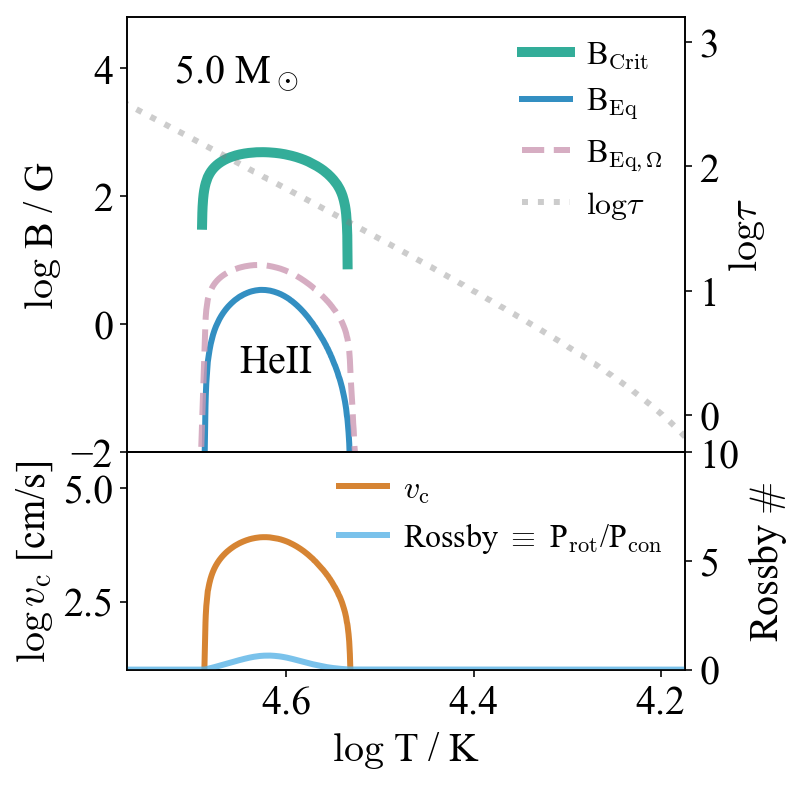

In [20]:
plt.rcParams['figure.figsize'] = (5,6)
mint=np.min(logt)
xylim=[4.77,mint]
lw=3
alpha = 0.8
gs1 = gridspec.GridSpec(2, 1,height_ratios=[2,1])
# No space between plots, e.g.: gs1.update(left=0.1, right=0.9, wspace=0.00,hspace=0.00)
gs1.update(wspace=0.00,hspace=0.00)

# Assign axis and remove xticks from top plot
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[1,0])
ax1.set_xticks([])

# Magnetic Fields

omega=veq/(radius[1]*rsun)
b=beq_omega(vcon,10**rho,hp,omega)

lns_bshutoff=ax1.plot(logt,np.log10(B_shutoff),c=BLUE_GREEN,label=r'B$_{\rm Crit}$',lw=lw+2,ls='-',alpha=alpha)
lns_beq=ax1.plot(logt,np.log10(beq(vcon,10**rho)),c=BLUE,label=r'B$_{\rm Eq}$',lw=lw,ls='-',alpha=alpha)#,label='Convective Velocity (cm/s)')
lns_beq_rot=ax1.plot(logt,np.log10(beq_omega(vcon,10**rho,hp,omega)),c=RED_PURPLE,label=r'B$_{\rm Eq, \Omega}$',lw=lw,ls='--',alpha=alpha)

ax1b = ax1.twinx()

lns_tau=ax1b.plot(logt,tau,c='gray',label=r'$\log \tau$ ',lw=lw,ls=':',alpha=alpha-0.4)

ax1b.set_ylim(-0.3,3.2)
ax1.set_ylim(-2,4.8)

ax1b.set_ylabel(r'$\log \tau$')
ax1.set_ylabel(r'$\log $ B / G')


lns2_vcon=ax2.plot(logt,np.log10(vcon),c=VERMILLION,label=r'$v_{\rm c}$',lw=lw,alpha=alpha)

ax2.set_ylim(1,5.8)
ax2b = ax2.twinx()

lns2_rossby=ax2b.plot(logt,rossby(vcon,veq,hp,req),c=SKY_BLUE,label=r'Rossby $\equiv$ P$_{\rm rot}$/P$_{\rm con}$',lw=lw,alpha=alpha)#,label='H$_{\rm P}$ [R$_\odot$]')
ax2b.set_ylim(0,10)


# added these three lines
lns = lns_bshutoff+lns_beq +lns_beq_rot +lns_tau
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right',handlelength=1.5,fontsize=16,ncol=1)
lns_low = lns2_vcon + lns2_rossby
labs2 = [l.get_label() for l in lns_low]
ax2.legend(lns_low, labs2, loc='upper right',handlelength=1.5,fontsize=16)


ax2.set_xlabel(r'$\log$ T / K')
ax2b.set_ylabel(r'Rossby $\#$')#(P$_{\rm rot}$/P$_{\rm c}$)')
ax2.set_ylabel(r'$\log \, v_{\rm c}$ [cm/s]')#(P$_{\rm rot}$/P$_{\rm c}$)')


ax1.set_xlim(xylim)
ax2.set_xlim(xylim)
ax1b.set_xlim(xylim)
ax2b.set_xlim(xylim)
fs=15
ax1.annotate('HeII',(4.65,-0.75), fontsize=fs+5)
#ax1.annotate('HeI',(4.27,-0.15), fontsize=fs+5)
ax1.annotate('H',(4.1,-0.15), fontsize=fs+5)
ax1.annotate(MASS+r' M$_\odot$',(4.72,3.8), fontsize=fs+5)



plt.savefig(FIGURES+MASS+"_b_shutoff_profile.pdf",bbox_inches='tight')


## For 9Msun Star

In [21]:
MASS = '9.0'
h=mr.MesaData(DIR+MASS+'/LOGS/history.data')
p=mr.MesaData(DIR+MASS+'/LOGS/profile20.data')

logt=np.log10(p.temperature)
kappa=p.opacity
hp=p.pressure_scale_height*rsun # cm/s
r=p.radius
mass=p.mass
dq=p.dq
pressure=p.pressure
luminosity=p.luminosity
mlt_mixing_length=p.mlt_mixing_length
mixing_type=p.mixing_type
grada=p.grada
gradr=p.gradr
superad=p.super_ad
mach=p.conv_vel_div_csound
veq = 211*1e5 #cm/s 
req= (max(r))*rsun #2.75*rsun #cm/s
#gradr=p.gradr
pressure=p.pressure
rho=p.logRho
age=p.star_age
tau=p.log_tau
mach=p.conv_vel_div_csound
vcon=10**(p.log_conv_vel)
B_shutoff=p.B_shutoff 
radius=p.radius
logt9=np.log10(p.Teff)
logl9=np.log10(p.photosphere_L)
data9=[logt9,logl9]
print(data9)

# Find fractional age
model = h.model_number 
logl = h.log_L
logg = h.log_g 
loglh=h.log_LH 
center_h1 = h.center_h1 
zams=find_zams(logl,loglh,model)
tams=find_tams(center_h1,model)
        
print('Fractional age:', p.star_age/h.star_age[tams])

# Set Rotational Velocity:
veq = 150e5 # km/s


[4.28733175987166, 3.9144703802907785]
Fractional age: 0.9472686519303704


/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10


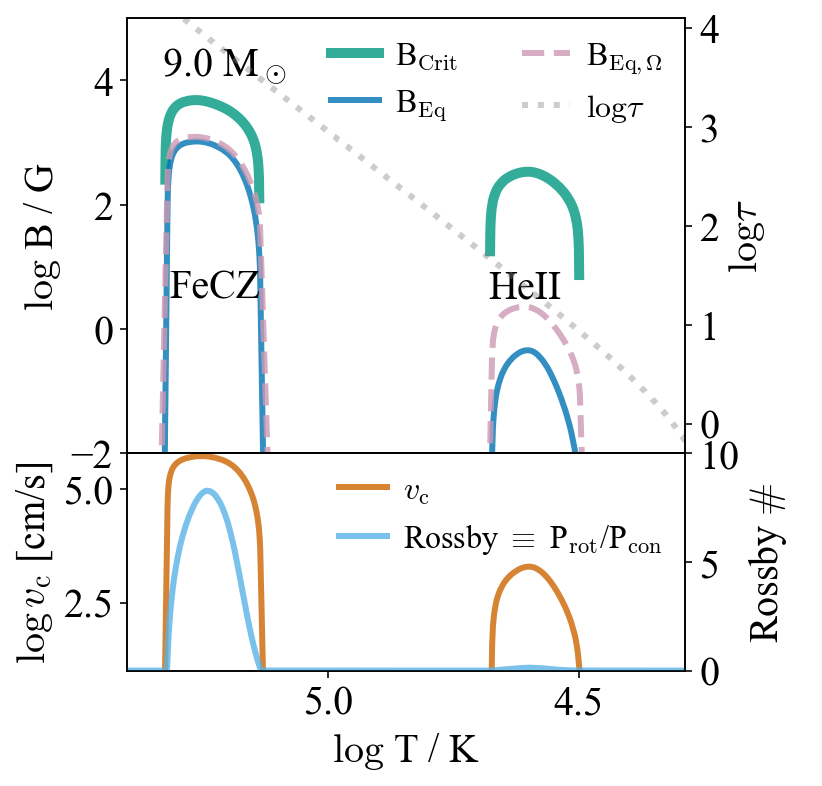

In [22]:

plt.rcParams['figure.figsize'] = (5,6)
mint=np.min(logt)
xylim=[5.4,mint]
lw=3
alpha = 0.8
gs1 = gridspec.GridSpec(2, 1,height_ratios=[2,1])
# No space between plots, e.g.: gs1.update(left=0.1, right=0.9, wspace=0.00,hspace=0.00)
gs1.update(wspace=0.00,hspace=0.00)

# Assign axis and remove xticks from top plot
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[1,0])
#ax3 = plt.subplot(gs1[2,0])
ax1.set_xticks([])

# Magnetic Fields

omega=veq/(radius[1]*rsun)
b=beq_omega(vcon,10**rho,hp,omega)

lns_bshutoff=ax1.plot(logt,np.log10(B_shutoff),c=BLUE_GREEN,label=r'B$_{\rm Crit}$',lw=lw+2,ls='-',alpha=alpha)
lns_beq=ax1.plot(logt,np.log10(beq(vcon,10**rho)),c=BLUE,label=r'B$_{\rm Eq}$',lw=lw,ls='-',alpha=alpha)#,label='Convective Velocity (cm/s)')
lns_beq_rot=ax1.plot(logt,np.log10(beq_omega(vcon,10**rho,hp,omega)),c=RED_PURPLE,label=r'B$_{\rm Eq, \Omega}$',lw=lw,ls='--',alpha=alpha)

ax1b = ax1.twinx()

lns_tau=ax1b.plot(logt,tau,c='gray',label=r'$\log \tau$ ',lw=lw,ls=':',alpha=alpha-0.4)

ax1b.set_ylim(-0.3,4.1)
ax1.set_ylim(-2,5)

ax1b.set_ylabel(r'$\log \tau$')
ax1.set_ylabel(r'$\log $ B / G')


lns2_vcon=ax2.plot(logt,np.log10(vcon),c=VERMILLION,label=r'$v_{\rm c}$',lw=lw,alpha=alpha)

ax2.set_ylim(1,5.8)
ax2b = ax2.twinx()

lns2_rossby=ax2b.plot(logt,rossby(vcon,veq,hp,req),c=SKY_BLUE,label=r'Rossby $\equiv$ P$_{\rm rot}$/P$_{\rm con}$',lw=lw,alpha=alpha)#,label='H$_{\rm P}$ [R$_\odot$]')
#lns2_mach=ax2b.plot(logt,mach*100,c=BLUE,label=r'Mach Number * 10',lw=lw,alpha=alpha)
#print(mach)
ax2b.set_ylim(0,10)

# Take care of legends
lns = lns_bshutoff+lns_beq +lns_beq_rot +lns_tau
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right',handlelength=1.5,fontsize=16,ncol=2)
lns_low = lns2_vcon + lns2_rossby
labs2 = [l.get_label() for l in lns_low]
ax2.legend(lns_low, labs2, loc='upper right',handlelength=1.5,fontsize=16)


ax2.set_xlabel(r'$\log$ T / K')
ax2b.set_ylabel(r'Rossby $\#$')#(P$_{\rm rot}$/P$_{\rm c}$)')
ax2.set_ylabel(r'$\log \, v_{\rm c}$ [cm/s]')#(P$_{\rm rot}$/P$_{\rm c}$)')

ax1.set_xlim(xylim)
ax2.set_xlim(xylim)
ax1b.set_xlim(xylim)
ax2b.set_xlim(xylim)
fs=15
ax1.annotate('FeCZ',(5.315,0.5), fontsize=fs+5)
ax1.annotate('HeII',(4.68,0.5), fontsize=fs+5)
ax1.annotate('HeI',(4.27,-0.15), fontsize=fs+5)
ax1.annotate('H',(4.1,-0.15), fontsize=fs+5)
ax1.annotate(MASS+r' M$_\odot$',(5.33,4.1), fontsize=fs+5)



plt.savefig(FIGURES+MASS+"_b_shutoff_profile.pdf",bbox_inches='tight')



/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in true_divide


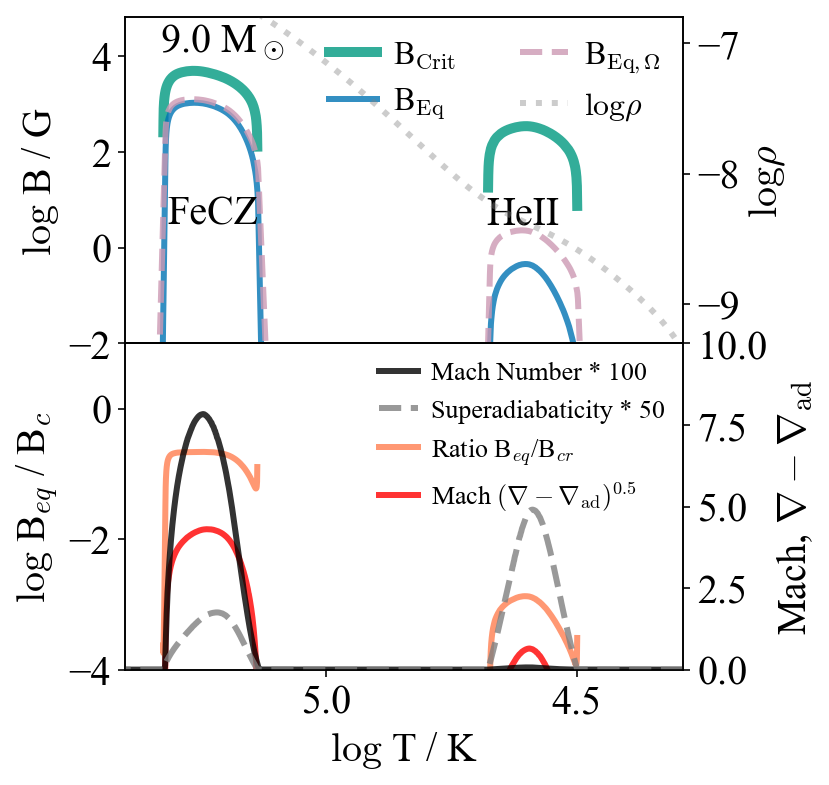

In [23]:

plt.rcParams['figure.figsize'] = (5,6)
mint=np.min(logt)
xylim=[5.4,mint]
lw=3
alpha = 0.8
gs1 = gridspec.GridSpec(2, 1,height_ratios=[1,1])
# No space between plots, e.g.: gs1.update(left=0.1, right=0.9, wspace=0.00,hspace=0.00)
gs1.update(wspace=0.00,hspace=0.00)

# Assign axis and remove xticks from top plot
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[1,0])
#ax3 = plt.subplot(gs1[2,0])
ax1.set_xticks([])

# Magnetic Fields

omega=veq/(radius[1]*rsun)
b=beq_omega(vcon,10**rho,hp,omega)

lns_bshutoff=ax1.plot(logt,np.log10(B_shutoff),c=BLUE_GREEN,label=r'B$_{\rm Crit}$',lw=lw+2,ls='-',alpha=alpha)
lns_beq=ax1.plot(logt,np.log10(beq(vcon,10**rho)),c=BLUE,label=r'B$_{\rm Eq}$',lw=lw,ls='-',alpha=alpha)#,label='Convective Velocity (cm/s)')
lns_beq_rot=ax1.plot(logt,np.log10(beq_omega(vcon,10**rho,hp,omega)),c=RED_PURPLE,label=r'B$_{\rm Eq, \Omega}$',lw=lw,ls='--',alpha=alpha)

ax1b = ax1.twinx()

lns_tau=ax1b.plot(logt,rho,c='gray',label=r'$\log \rho$ ',lw=lw,ls=':',alpha=alpha-0.4)

ax1b.set_ylim(-9.3,-6.8)
ax1.set_ylim(-2,4.8)

ax1b.set_ylabel(r'$\log \rho$')
ax1.set_ylabel(r'$\log $ B / G')


#lns2_vcon=ax2.plot(logt,np.log10(vcon),c=VERMILLION,label=r'$v_{\rm c}$',lw=lw,alpha=alpha)
lns2_ratio_theory=ax2.plot(logt,np.log10(mach*((superad)**0.5)),c='red',label=r'Mach $(\nabla - \nabla_{\rm ad})^{0.5}$',ls='-',lw=lw,alpha=alpha)
lns2_ratio=ax2.plot(logt,np.log10(beq(vcon,10**rho)/B_shutoff),c='coral',label=r'Ratio B$_{eq}$/B$_{cr}$',ls='-',lw=lw,alpha=alpha)

ax2.set_ylim(-4,1)
ax2b = ax2.twinx()




#lns2_rossby=ax2b.plot(logt,rossby(vcon,veq,hp,req),c=SKY_BLUE,label=r'Rossby $\equiv$ P$_{\rm rot}$/P$_{\rm con}$',lw=lw,alpha=alpha)#,label='H$_{\rm P}$ [R$_\odot$]')
ax2b.set_ylim(0,10)

lns2_mach=ax2b.plot(logt,mach*100,c='black',label=r'Mach Number * 100',lw=lw,alpha=alpha)
lns2_superad=ax2b.plot(logt,superad*50,c='gray',label=r'Superadiabaticity * 50',ls='--',lw=lw,alpha=alpha)

#print(mach)

# Take care of legends
lns = lns_bshutoff+lns_beq +lns_beq_rot +lns_tau
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right',handlelength=1.5,fontsize=16,ncol=2)
#lns_low = lns2_vcon + lns2_rossby
lns_low = lns2_mach + lns2_superad + lns2_ratio +lns2_ratio_theory
labs2 = [l.get_label() for l in lns_low]
ax2.legend(lns_low, labs2, loc='upper right',handlelength=1.5,fontsize=13)


ax2.set_xlabel(r'$\log$ T / K')
ax2b.set_ylabel(r'Mach, $\nabla - \nabla_{\rm ad}$')#(P$_{\rm rot}$/P$_{\rm c}$)')
ax2.set_ylabel(r'$\log$ B$_{eq}$ / B$_c$')#(P$_{\rm rot}$/P$_{\rm c}$)')

ax1.set_xlim(xylim)
ax2.set_xlim(xylim)
ax1b.set_xlim(xylim)
ax2b.set_xlim(xylim)
fs=15
ax1.annotate('FeCZ',(5.315,0.5), fontsize=fs+5)
ax1.annotate('HeII',(4.68,0.5), fontsize=fs+5)
ax1.annotate('HeI',(4.27,-0.15), fontsize=fs+5)
ax1.annotate('H',(4.1,-0.15), fontsize=fs+5)
ax1.annotate(MASS+r' M$_\odot$',(5.33,4.1), fontsize=fs+5)



plt.savefig(FIGURES+MASS+"_b_shutoff_profile_density.pdf",bbox_inches='tight')



## Make HRD Plots for B$_{\rm Crit}$
### Start with both FeCZ and HeCZ

In [29]:
mods = [ 2.0, 2.2, 2.4,2.6, 2.8, 3.0,3.2, 3.4, 3.6 ,3.8, 4.0 ,4.2, 4.4 ,4.6 ,4.8 ,5.0, 5.2, 5.4 ,5.6 ,5.8, 6.0, 7.0,8.0,9.0,10,11,12]#,13,14,15]
hrdlines = [2.0,2.4,3.0,4.0,5.0,6.0,7.0,9.0,11,12]#,15]# ,20,25,30,40,60,80,120]

# STRINGS

bbar=r'$\log_{10} \, B_{\rm crit}$ / G'
bsbar=r'$\log_{10} \, B_{\rm Surface}$ / G'
logteff=r'$\log_{10}\, T_{\rm eff}$/K'
logell=r'$\log_{10}\, L$/L$_\odot$'


/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:283: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 1]*y +
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:284: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 2])
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


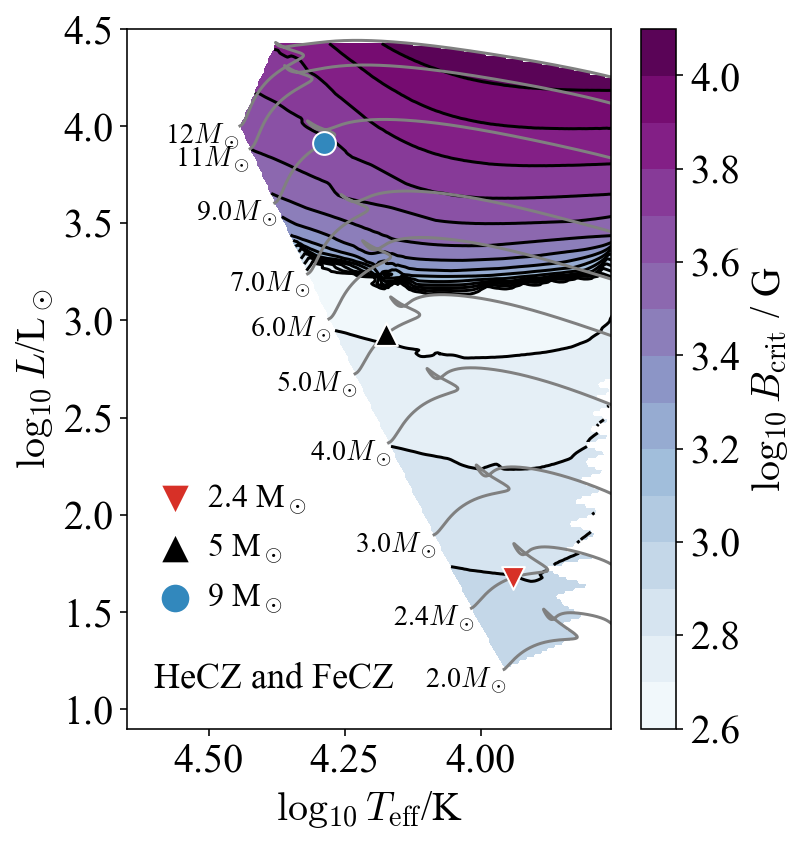

In [30]:
# Use ell_sun to make Spectroscopic HRD, if needed
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      HI_B_shutoff_conv = h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= h.FeCZ_B_shutoff_conv
    
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,HI_B_shutoff_conv,FeCZ_B_shutoff_conv])
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,FeCZ_B_shutoff_conv])

      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_shutoff_conv[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)
    #z=((1/z)*1e6)/1.6 # in microHz (the 1.6 is to correct for alpha_mixing lenght, as I calculated turnover timescales as alpha*<Hp>/<vconv>

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    
    
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='BuPu' ,setlims=True) #cmap="YlOrRd")cmap='YlGnBu' cmap='plasma'
    
    # fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\nu_{char}$ ($\mu$Hz)')
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.07
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=14) # ,verticalalignment='center',rotation='vertical',  
            
    
    # ADD LOCATION OF EXTRACTED PROFILES
    LOC=[(r'2.4 M$_\odot$',logt2,logl2,'v'),(r'5 M$_\odot$',logt5,logl5,'^'),(r'9 M$_\odot$',logt9,logl9,'o')] 
    COL=[RED_PURPLE,SKY_BLUE,BLUE_GREEN]
    COL=['salmon','darkgray','slateblue']
    COL=['tab:orange','tab:blue','lightsteelblue']
    COL=['#fbb4ae','#b3cde3','#ccebc5'] # Colorblind friendly https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
    COL=['#d73027','black','#3288bd']

    for i in range(len(LOC[0])-1):
        #print(i)
        ax.scatter(LOC[i][1],LOC[i][2],label=LOC[i][0],marker=LOC[i][3],s=130,edgecolors='white',lw=1.0,zorder=3,color=COL[i])#,mks=10)
    legend = ax.legend(loc='lower left',fontsize=16,bbox_to_anchor=(0.02,0.13),markerscale=1.3)#,frameon = True)
    
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.text(4.6,1.11,'HeCZ and FeCZ',fontsize=18)
    ax.set_xlim([4.65,3.76])
    ax.set_ylim([0.9,4.5])
   # ax.text(4.65,4.4,'Z=0.02',fontsize=19)

   
    
    
   # plt.title(r'Subsurface Convection B$_{\rm Crit}$')
    plt.savefig(FIGURES+"B_shutoff.pdf",bbox_inches='tight')

read_models(DIR,mods)


## With Fractional Ages:


/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:59: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:283: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 1]*y +
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:284: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 2])
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


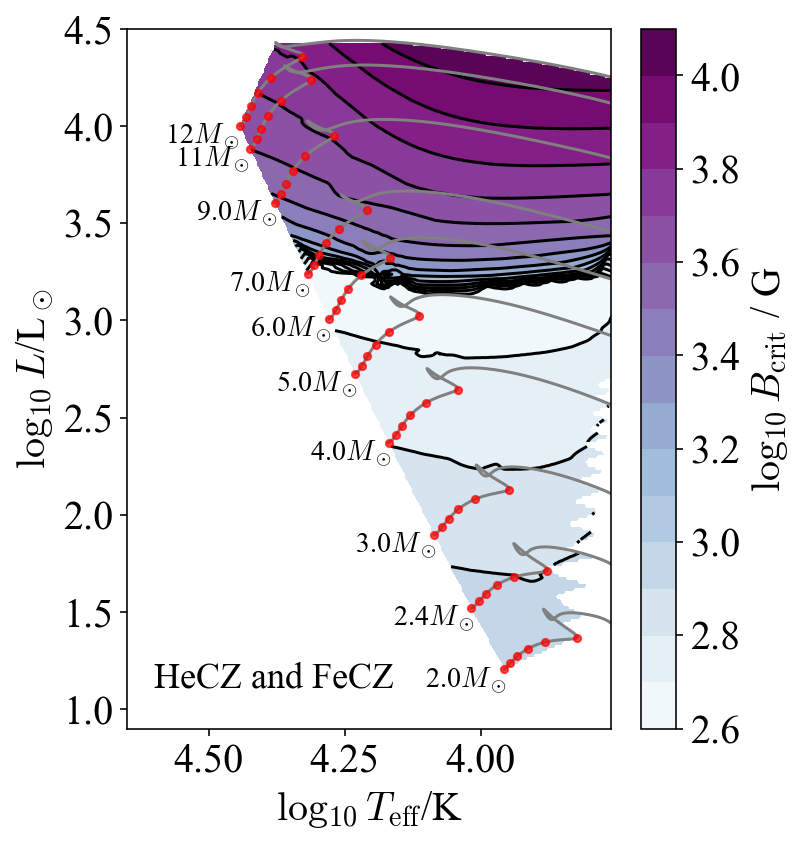

In [31]:
# Use ell_sun to make Spectroscopic HRD, if needed
frac = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]       
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      HI_B_shutoff_conv = h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= h.FeCZ_B_shutoff_conv
    
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,HI_B_shutoff_conv,FeCZ_B_shutoff_conv])
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,FeCZ_B_shutoff_conv])

      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_shutoff_conv[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)
    #z=((1/z)*1e6)/1.6 # in microHz (the 1.6 is to correct for alpha_mixing lenght, as I calculated turnover timescales as alpha*<Hp>/<vconv>

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    
    
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='BuPu' ,setlims=True) #cmap="YlOrRd")cmap='YlGnBu' cmap='plasma'
    
    # fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\nu_{char}$ ($\mu$Hz)')
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.07
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        star_age=h.star_age
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=14) # ,verticalalignment='center',rotation='vertical',
        for fraction in frac:
         a=find_frac_ms(model,star_age,zams,tams,fraction)    
         ax.scatter(logt[a],logl[a],marker='o',s=13,c='red',zorder=3,alpha=0.7)
            
    
    # ADD LOCATION OF EXTRACTED PROFILES
    LOC=[(r'2.4 M$_\odot$',logt2,logl2,'v'),(r'5 M$_\odot$',logt5,logl5,'^'),(r'9 M$_\odot$',logt9,logl9,'o')] 
    COL=[RED_PURPLE,SKY_BLUE,BLUE_GREEN]
    COL=['salmon','darkgray','slateblue']
    COL=['tab:orange','tab:blue','lightsteelblue']
    COL=['#fbb4ae','#b3cde3','#ccebc5'] # Colorblind friendly https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
    COL=['#d73027','black','#3288bd']

    #for i in range(len(LOC[0])-1):
        #print(i)
    #    ax.scatter(LOC[i][1],LOC[i][2],label=LOC[i][0],marker=LOC[i][3],s=130,edgecolors='white',lw=1.0,zorder=3,color=COL[i])#,mks=10)
    #legend = ax.legend(loc='lower left',fontsize=16,bbox_to_anchor=(0.02,0.13),markerscale=1.3)#,frameon = True)
    
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.text(4.6,1.11,'HeCZ and FeCZ',fontsize=18)
    ax.set_xlim([4.65,3.76])
    ax.set_ylim([0.9,4.5])
   # ax.text(4.65,4.4,'Z=0.02',fontsize=19)

   
    
    
   # plt.title(r'Subsurface Convection B$_{\rm Crit}$')
    plt.savefig(FIGURES+"B_shutoff_age.pdf",bbox_inches='tight')

read_models(DIR,mods)


## Let's plot the critical magnetic flux

/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


2.4 M$_\odot$
3.9414023101459055
1.676670432408777


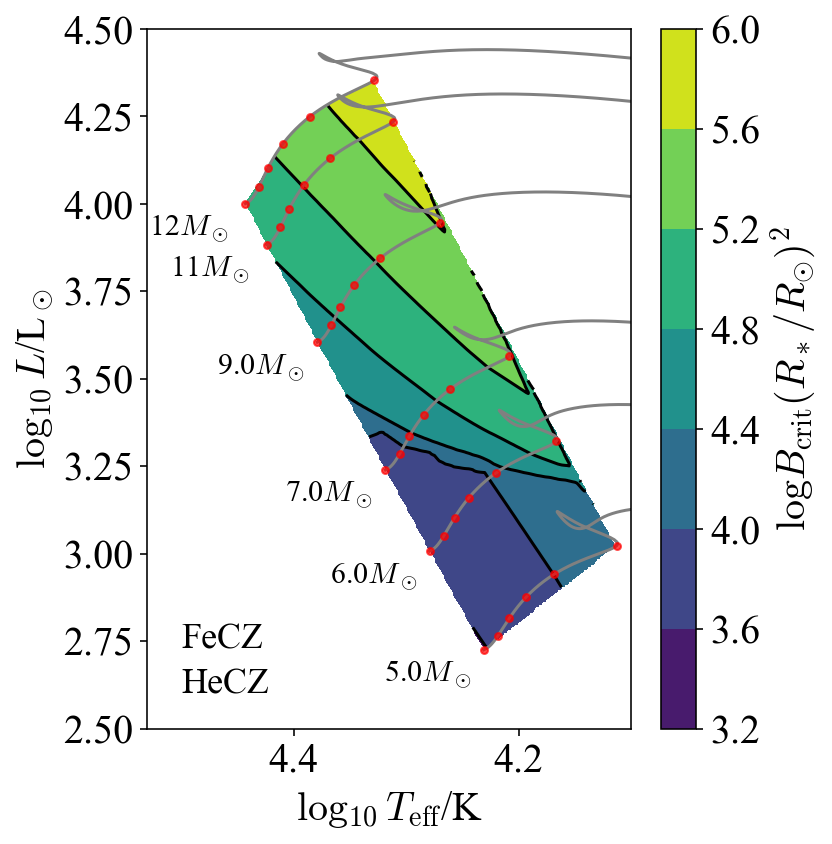

In [32]:
mods = [ 5.0, 5.2, 5.4 ,5.6 ,5.8, 6.0, 7.0,8.0,9.0,10,11,12]#,13,14,15]
hrdlines = [5.0,6.0,7.0,9.0,11,12]#,15]# ,20,25,30,40,60,80,120]
            
frac = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]            
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      radius = 10**h.log_R   
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
      
    
    
      HI_B_shutoff_conv = (radius**2.0)*h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = (radius**2.0)*h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= (radius**2.0)*h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= (radius**2.0)*h.FeCZ_B_shutoff_conv
      max_B_shutoff_conv = np.maximum.reduce([FeCZ_B_shutoff_conv,HeII_B_shutoff_conv,HeI_B_shutoff_conv])
       
     # max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,HI_B_shutoff_conv])

      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:tams])
      y.append(logl[zams:tams])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_shutoff_conv[zams:tams])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 6, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 6, cmap='viridis'  ,setlims=True) #cmap="YlOrRd") cmap='plasma' cmap='YlGnBu'
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\log B_{\rm crit} (R_*/R_{\odot})^2$')
    plt.gca().invert_xaxis()
    
   
    dt = 0.05
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        star_age = h.star_age
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=15) # ,verticalalignment='center',rotation='vertical',  
        for fraction in frac:
         a=find_frac_ms(model,star_age,zams,tams,fraction)    
         ax.scatter(logt[a],logl[a],marker='o',s=12,c='red',zorder=3,alpha=0.7)
    
    
     # ADD LOCATION OF EXTRACTED PROFILES
    LOC=[(r'2.4 M$_\odot$',logt2,logl2,'v'),(r'5 M$_\odot$',logt5,logl5,'^'),(r'9 M$_\odot$',logt9,logl9,'o')] 
    COL=[RED_PURPLE,SKY_BLUE,BLUE_GREEN]
    COL=['salmon','darkgray','slateblue']
    COL=['tab:orange','tab:blue','lightsteelblue']
    COL=['#fbb4ae','#b3cde3','#ccebc5'] # Colorblind friendly https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
    COL=['#d73027','darkgray','#3288bd']
    print(LOC[0][0])
    print(LOC[0][1])
    print(LOC[0][2])
  #  for i in range(len(LOC[0])-2):
  #      print(i)
  #      ax.scatter(LOC[i][1],LOC[i][2],label=LOC[i][0],marker=LOC[i][3],s=130,edgecolors='white',lw=1.0,zorder=3,color=COL[i])#,mks=10)
  #  legend = ax.legend(loc='lower left',fontsize=16,bbox_to_anchor=(0.02,0.13),markerscale=1.3)#,frameon = True)
    
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.text(4.5,2.73,'FeCZ',fontsize=18)
    ax.text(4.5,2.6,'HeCZ',fontsize=18)
    ax.set_xlim([4.53,4.1])
    ax.set_ylim([2.5,4.5])
   # ax.text(4.65,4.4,'Z=0.02',fontsize=19)
    
 #   plt.title(r'He Convection B$_{\rm Crit}$')
    plt.savefig(FIGURES+"B_shutoff_FeCZ_age_flux.pdf",bbox_inches='tight')

read_models(DIR,mods)
            

/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


2.4 M$_\odot$
3.9414023101459055
1.676670432408777


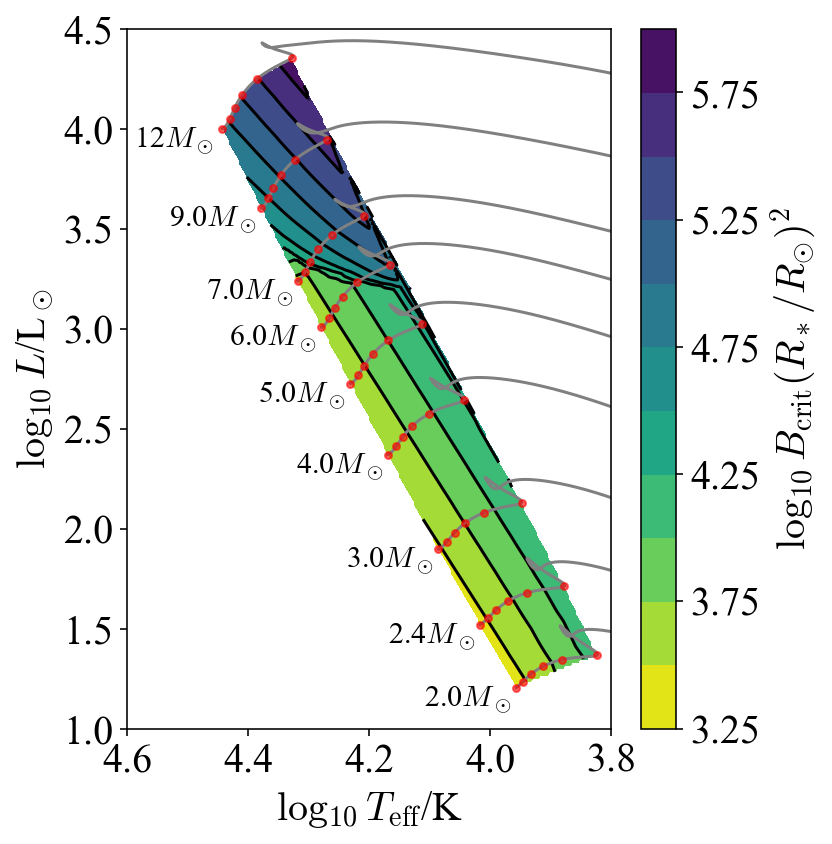

In [33]:
mods = [ 2.0, 2.2, 2.4,2.6, 2.8, 3.0,3.2, 3.4, 3.6 ,3.8, 4.0 ,4.2, 4.4 ,4.6 ,4.8 ,5.0, 5.2, 5.4 ,5.6 ,5.8, 6.0, 7.0,8.0,9.0,10,11,12]#,13,14,15]
hrdlines = [2.0,2.4,3.0,4.0,5.0,6.0,7.0,9.0,12]#,15]# ,20,25,30,40,60,80,120]

            
frac = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]            
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      radius = 10**h.log_R   
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
      
    
    
      HI_B_shutoff_conv = (radius**2.0)*h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = (radius**2.0)*h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= (radius**2.0)*h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= (radius**2.0)*h.FeCZ_B_shutoff_conv
      max_B_shutoff_conv = np.maximum.reduce([FeCZ_B_shutoff_conv,HeII_B_shutoff_conv,HeI_B_shutoff_conv])
       
     # max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,HI_B_shutoff_conv])

      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:tams])
      y.append(logl[zams:tams])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_shutoff_conv[zams:tams])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 10, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 10, cmap='viridis_r'  ,setlims=True) #cmap="YlOrRd") cmap='plasma' cmap='YlGnBu'
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\log_{10} \, B_{\rm crit} (R_*/R_{\odot})^2$')
    plt.gca().invert_xaxis()
    
   
    dt = 0.08
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        star_age = h.star_age
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=15) # ,verticalalignment='center',rotation='vertical',  
        for fraction in frac:
         a=find_frac_ms(model,star_age,zams,tams,fraction)    
         ax.scatter(logt[a],logl[a],marker='o',s=12,c='red',zorder=3,alpha=0.6)
    
    
     # ADD LOCATION OF EXTRACTED PROFILES
    LOC=[(r'2.4 M$_\odot$',logt2,logl2,'v'),(r'5 M$_\odot$',logt5,logl5,'^'),(r'9 M$_\odot$',logt9,logl9,'o')] 
    COL=[RED_PURPLE,SKY_BLUE,BLUE_GREEN]
    COL=['salmon','darkgray','slateblue']
    COL=['tab:orange','tab:blue','lightsteelblue']
    COL=['#fbb4ae','#b3cde3','#ccebc5'] # Colorblind friendly https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
    COL=['#d73027','darkgray','#3288bd']
    print(LOC[0][0])
    print(LOC[0][1])
    print(LOC[0][2])
  #  for i in range(len(LOC[0])-2):
  #      print(i)
  #      ax.scatter(LOC[i][1],LOC[i][2],label=LOC[i][0],marker=LOC[i][3],s=130,edgecolors='white',lw=1.0,zorder=3,color=COL[i])#,mks=10)
  #  legend = ax.legend(loc='lower left',fontsize=16,bbox_to_anchor=(0.02,0.13),markerscale=1.3)#,frameon = True)
    
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
   # ax.text(4.5,2.73,'FeCZ',fontsize=18)
   # ax.text(4.5,2.6,'HeCZ',fontsize=18)
    ax.set_xlim([4.6,3.8])
    ax.set_ylim([1.0,4.5])
   # ax.text(4.65,4.4,'Z=0.02',fontsize=19)
    
 #   plt.title(r'He Convection B$_{\rm Crit}$')
    plt.savefig(FIGURES+"B_shutoff_FeCZ_age_flux.pdf",bbox_inches='tight')

read_models(DIR,mods)
            

/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:65: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:283: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 1]*y +
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:284: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 2])
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


2.4 M$_\odot$
3.9414023101459055
1.676670432408777
0
1
2


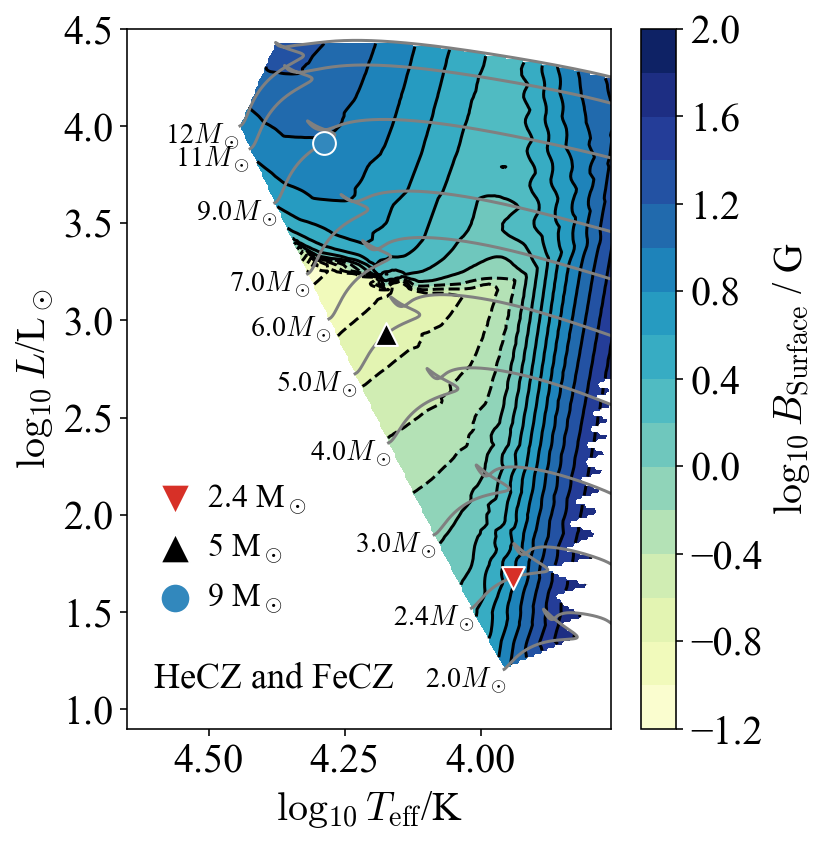

In [34]:
# Use ell_sun to make Spectroscopic HRD, if needed
mods = [ 2.0, 2.2, 2.4,2.6, 2.8, 3.0,3.2, 3.4, 3.6 ,3.8, 4.0 ,4.2, 4.4 ,4.6 ,4.8 ,5.0, 5.2, 5.4 ,5.6 ,5.8, 6.0, 7.0,8.0,9.0,10,11,12]#,13,14,15]
hrdlines = [2.0,2.4,3.0,4.0,5.0,6.0,7.0,9.0,11,12]#,15]# ,20,25,30,40,60,80,120]

ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      b_FeCZ_surf     = h.b_FeCZ_surf
      b_FeCZ_surf_max = h.b_FeCZ_surf_max 
      b_HeII_surf     = h.b_HeII_surf
      b_HeII_surf_max = h.b_HeII_surf_max 
      b_HeI_surf      = h.b_HeI_surf
      b_HeI_surf_max  = h.b_HeI_surf_max 
    
      
      max_B_surf = np.maximum.reduce([b_FeCZ_surf,b_HeII_surf,b_HeI_surf])
      #max_B_surf_max = np.maximum.reduce([b_FeCZ_surf_max,b_HeII_surf_max,b_HeI_surf_max])
    
    
      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_surf[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)
    #z=((1/z)*1e6)/1.6 # in microHz (the 1.6 is to correct for alpha_mixing lenght, as I calculated turnover timescales as alpha*<Hp>/<vconv>

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlGnBu',setlims=True) #cmap="YlOrRd")
    # fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\nu_{char}$ ($\mu$Hz)')
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bsbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.07
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=14) # ,verticalalignment='center',rotation='vertical',  
    
    
    
      # ADD LOCATION OF EXTRACTED PROFILES
    LOC=[(r'2.4 M$_\odot$',logt2,logl2,'v'),(r'5 M$_\odot$',logt5,logl5,'^'),(r'9 M$_\odot$',logt9,logl9,'o')] 
    COL=[RED_PURPLE,SKY_BLUE,BLUE_GREEN]
    COL=['salmon','darkgray','slateblue']
    COL=['tab:orange','tab:blue','lightsteelblue']
    COL=['#fbb4ae','#b3cde3','#ccebc5'] # Colorblind friendly https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
    COL=['#d73027','black','#3288bd']
    print(LOC[0][0])
    print(LOC[0][1])
    print(LOC[0][2])
    for i in range(len(LOC[0])-1):
        print(i)
        ax.scatter(LOC[i][1],LOC[i][2],label=LOC[i][0],marker=LOC[i][3],s=130,edgecolors='white',lw=1.0,zorder=3,color=COL[i])#,mks=10)
    legend = ax.legend(loc='lower left',fontsize=16,bbox_to_anchor=(0.02,0.13),markerscale=1.3)#,frameon = True)
    
    
    

    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.text(4.6,1.11,'HeCZ and FeCZ',fontsize=18)
  
    
    ax.set_xlim([4.65,3.76])
    ax.set_ylim([0.9,4.5])
    
    
  #  ax.text(4.65,4.4,'Z=0.02',fontsize=19)
    
#    plt.title(r'Subsurface Convection Max(B$_{\rm Surf})$')
    plt.savefig(FIGURES+"B_surface.pdf",bbox_inches='tight')

read_models(DIR,mods)


### Same but just HeCZ

In [35]:
mods = [ 2.0, 2.2, 2.4,2.6, 2.8, 3.0,3.2, 3.4, 3.6 ,3.8, 4.0 ,4.2, 4.4 ,4.6 ,4.8 ,5.0, 5.2, 5.4 ,5.6 ,5.8, 6.0]#, 7.0,8.0,9.0]#,10,11,12,13,14,15]
hrdlines = [2.0,2.4,3.0,4.0,5.0,6.0]#,7.0,9.0]#,11,13,15]# ,20,25,30,40,60,80,120]

/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:283: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 1]*y +
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:284: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 2])
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


2.4 M$_\odot$
3.9414023101459055
1.676670432408777


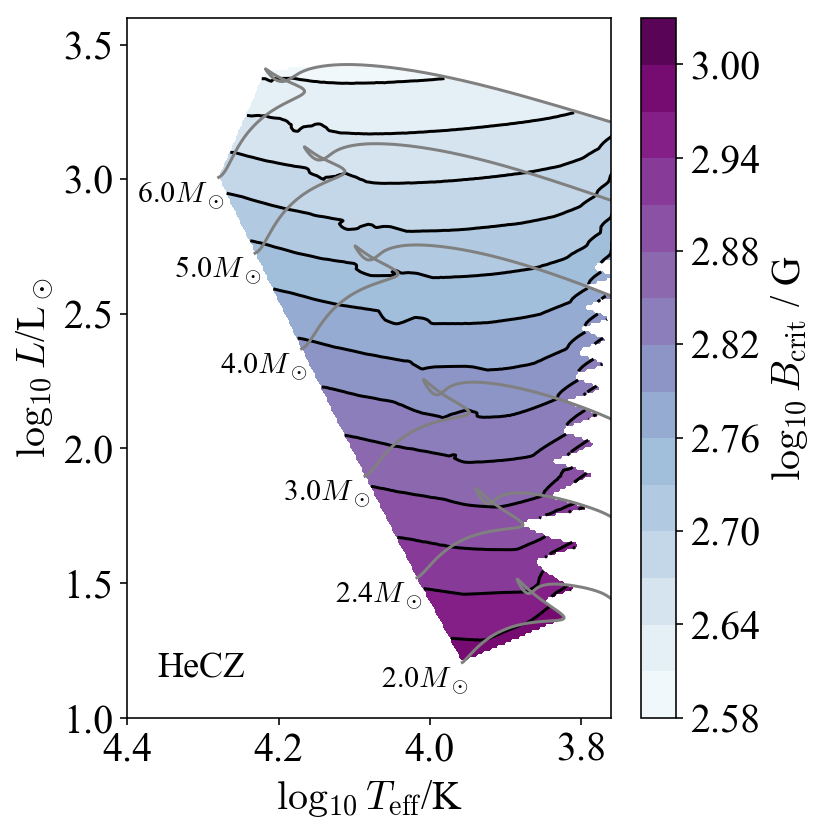

In [36]:
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
      
    
    
      HI_B_shutoff_conv = h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= h.FeCZ_B_shutoff_conv
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv])
     # max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,HI_B_shutoff_conv])

      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_shutoff_conv[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='BuPu'  ,setlims=True) #cmap="YlOrRd") cmap='plasma' cmap='YlGnBu'
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.05
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=15) # ,verticalalignment='center',rotation='vertical',  
    
    
     # ADD LOCATION OF EXTRACTED PROFILES
    LOC=[(r'2.4 M$_\odot$',logt2,logl2,'v'),(r'5 M$_\odot$',logt5,logl5,'^'),(r'9 M$_\odot$',logt9,logl9,'o')] 
    COL=[RED_PURPLE,SKY_BLUE,BLUE_GREEN]
    COL=['salmon','darkgray','slateblue']
    COL=['tab:orange','tab:blue','lightsteelblue']
    COL=['#fbb4ae','#b3cde3','#ccebc5'] # Colorblind friendly https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
    COL=['#d73027','darkgray','#3288bd']
    print(LOC[0][0])
    print(LOC[0][1])
    print(LOC[0][2])
  #  for i in range(len(LOC[0])-2):
  #      print(i)
  #      ax.scatter(LOC[i][1],LOC[i][2],label=LOC[i][0],marker=LOC[i][3],s=130,edgecolors='white',lw=1.0,zorder=3,color=COL[i])#,mks=10)
  #  legend = ax.legend(loc='lower left',fontsize=16,bbox_to_anchor=(0.02,0.13),markerscale=1.3)#,frameon = True)
    
    ax.text(4.36,1.15,'HeCZ',fontsize=18)    
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.set_xlim([4.4,3.76])
    ax.set_ylim([1.0,3.6])
    
 #   plt.title(r'He Convection B$_{\rm Crit}$')
    plt.savefig(FIGURES+"B_shutoff_He.pdf",bbox_inches='tight')

read_models(DIR,mods)


## Add fractional MS points

/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:283: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 1]*y +
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:284: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 2])
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


2.4 M$_\odot$
3.9414023101459055
1.676670432408777


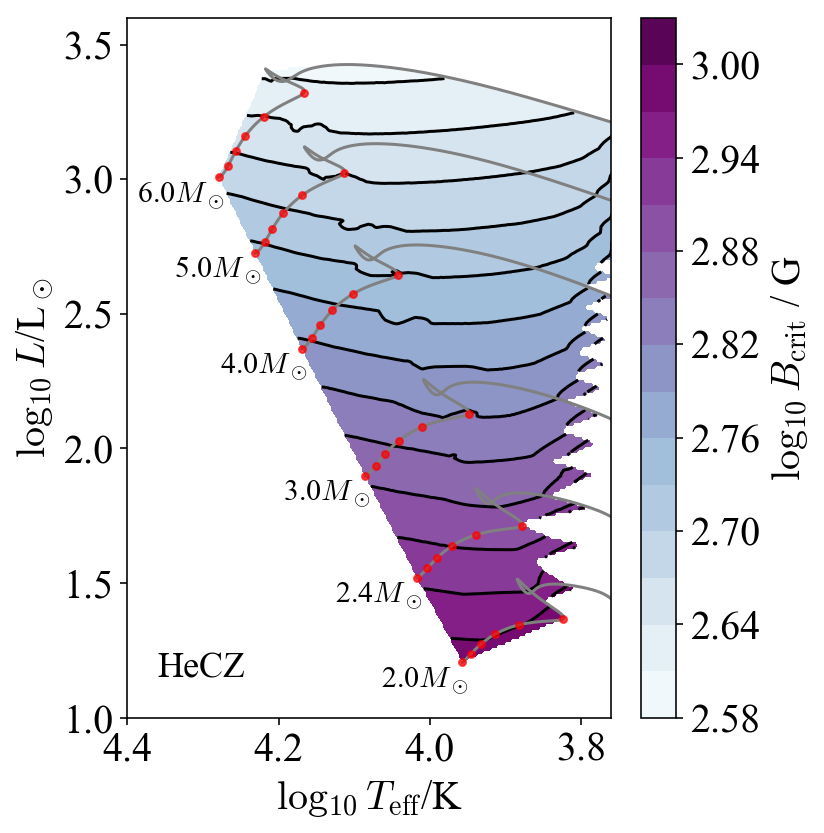

In [37]:

            
frac = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]            
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
      
    
    
      HI_B_shutoff_conv = h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= h.FeCZ_B_shutoff_conv
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv])
     # max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,HI_B_shutoff_conv])

      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_shutoff_conv[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='BuPu'  ,setlims=True) #cmap="YlOrRd") cmap='plasma' cmap='YlGnBu'
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.05
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        star_age = h.star_age
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=15) # ,verticalalignment='center',rotation='vertical',  
        for fraction in frac:
         a=find_frac_ms(model,star_age,zams,tams,fraction)    
         ax.scatter(logt[a],logl[a],marker='o',s=12,c='red',zorder=3,alpha=0.7)
    
    
     # ADD LOCATION OF EXTRACTED PROFILES
    LOC=[(r'2.4 M$_\odot$',logt2,logl2,'v'),(r'5 M$_\odot$',logt5,logl5,'^'),(r'9 M$_\odot$',logt9,logl9,'o')] 
    COL=[RED_PURPLE,SKY_BLUE,BLUE_GREEN]
    COL=['salmon','darkgray','slateblue']
    COL=['tab:orange','tab:blue','lightsteelblue']
    COL=['#fbb4ae','#b3cde3','#ccebc5'] # Colorblind friendly https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
    COL=['#d73027','darkgray','#3288bd']
    print(LOC[0][0])
    print(LOC[0][1])
    print(LOC[0][2])
  #  for i in range(len(LOC[0])-2):
  #      print(i)
  #      ax.scatter(LOC[i][1],LOC[i][2],label=LOC[i][0],marker=LOC[i][3],s=130,edgecolors='white',lw=1.0,zorder=3,color=COL[i])#,mks=10)
  #  legend = ax.legend(loc='lower left',fontsize=16,bbox_to_anchor=(0.02,0.13),markerscale=1.3)#,frameon = True)
    
    ax.text(4.36,1.15,'HeCZ',fontsize=18)    
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.set_xlim([4.4,3.76])
    ax.set_ylim([1.0,3.6])
    
 #   plt.title(r'He Convection B$_{\rm Crit}$')
    plt.savefig(FIGURES+"B_shutoff_He_age.pdf",bbox_inches='tight')

read_models(DIR,mods)
            

## Let's plot the Critical Magnetic Flux

/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


2.4 M$_\odot$
3.9414023101459055
1.676670432408777


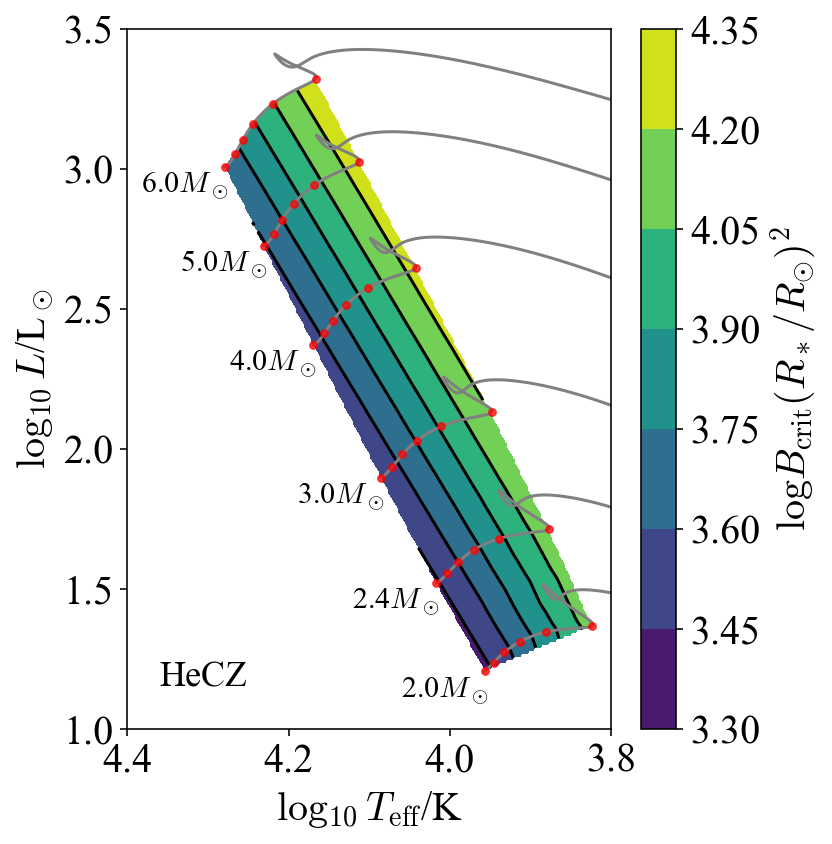

In [38]:

            
frac = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]            
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      radius = 10**h.log_R   
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
      
    
    
      HI_B_shutoff_conv = (radius**2.0)*h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = (radius**2.0)*h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= (radius**2.0)*h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= (radius**2.0)*h.FeCZ_B_shutoff_conv
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv])
       
     # max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,HI_B_shutoff_conv])

      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:tams])
      y.append(logl[zams:tams])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_shutoff_conv[zams:tams])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 6, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 6, cmap='viridis'  ,setlims=True) #cmap="YlOrRd") cmap='plasma' cmap='YlGnBu'
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\log B_{\rm crit} (R_*/R_{\odot})^2$')
    plt.gca().invert_xaxis()
    
   
    dt = 0.05
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        star_age = h.star_age
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=15) # ,verticalalignment='center',rotation='vertical',  
        for fraction in frac:
         a=find_frac_ms(model,star_age,zams,tams,fraction)    
         ax.scatter(logt[a],logl[a],marker='o',s=12,c='red',zorder=3,alpha=0.7)
    
    
     # ADD LOCATION OF EXTRACTED PROFILES
    LOC=[(r'2.4 M$_\odot$',logt2,logl2,'v'),(r'5 M$_\odot$',logt5,logl5,'^'),(r'9 M$_\odot$',logt9,logl9,'o')] 
    COL=[RED_PURPLE,SKY_BLUE,BLUE_GREEN]
    COL=['salmon','darkgray','slateblue']
    COL=['tab:orange','tab:blue','lightsteelblue']
    COL=['#fbb4ae','#b3cde3','#ccebc5'] # Colorblind friendly https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
    COL=['#d73027','darkgray','#3288bd']
    print(LOC[0][0])
    print(LOC[0][1])
    print(LOC[0][2])
  #  for i in range(len(LOC[0])-2):
  #      print(i)
  #      ax.scatter(LOC[i][1],LOC[i][2],label=LOC[i][0],marker=LOC[i][3],s=130,edgecolors='white',lw=1.0,zorder=3,color=COL[i])#,mks=10)
  #  legend = ax.legend(loc='lower left',fontsize=16,bbox_to_anchor=(0.02,0.13),markerscale=1.3)#,frameon = True)
    
    ax.text(4.36,1.15,'HeCZ',fontsize=18)    
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.set_xlim([4.4,3.8])
    ax.set_ylim([1.0,3.5])
    
 #   plt.title(r'He Convection B$_{\rm Crit}$')
    plt.savefig(FIGURES+"B_shutoff_He_age_flux.pdf",bbox_inches='tight')

read_models(DIR,mods)
            

/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:283: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 1]*y +
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:284: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 2])
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


2.4 M$_\odot$
3.9414023101459055
1.676670432408777


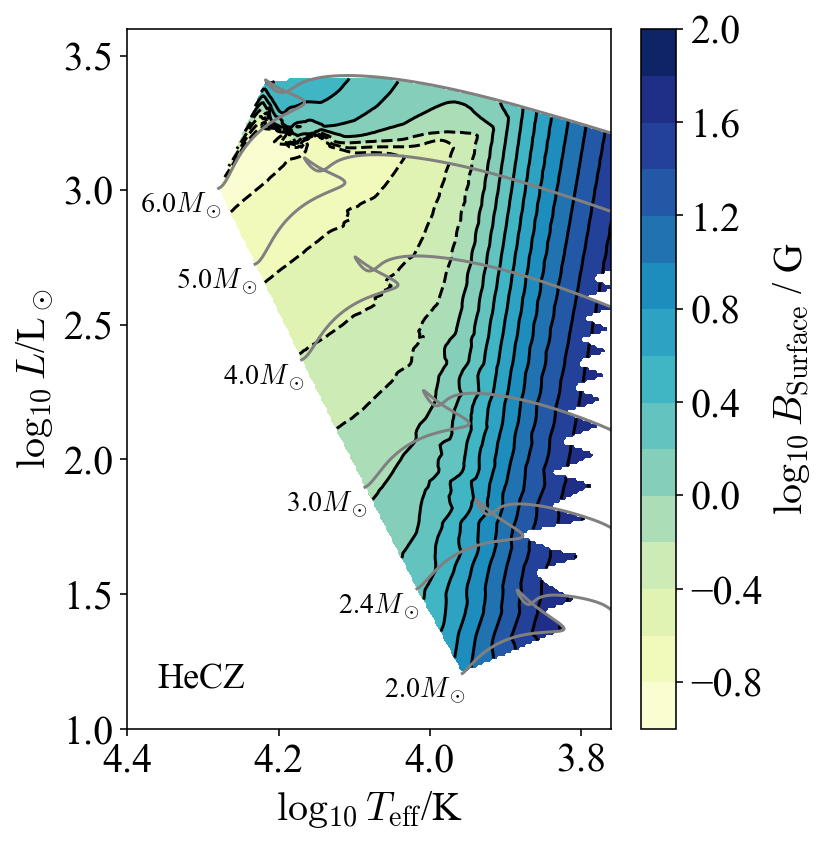

In [39]:
# Use ell_sun to make Spectroscopic HRD, if needed
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      b_FeCZ_surf     = h.b_FeCZ_surf
      b_FeCZ_surf_max = h.b_FeCZ_surf_max 
      b_HeII_surf     = h.b_HeII_surf
      b_HeII_surf_max = h.b_HeII_surf_max 
      b_HeI_surf      = h.b_HeI_surf
      b_HeI_surf_max  = h.b_HeI_surf_max 
    
      max_B_surf = np.maximum.reduce([b_FeCZ_surf,b_HeII_surf,b_HeI_surf])
      max_B_surf_max = np.maximum.reduce([b_FeCZ_surf_max,b_HeII_surf_max,b_HeI_surf_max])
    
    
      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_surf[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)
    #z=((1/z)*1e6)/1.6 # in microHz (the 1.6 is to correct for alpha_mixing lenght, as I calculated turnover timescales as alpha*<Hp>/<vconv>

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlGnBu' ,setlims=True) #cmap="YlOrRd") cmap='viridis'
    # fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\nu_{char}$ ($\mu$Hz)')
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bsbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.05
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=14) # ,verticalalignment='center',rotation='vertical',  
    
    # ADD LOCATION OF EXTRACTED PROFILES
    LOC=[(r'2.4 M$_\odot$',logt2,logl2,'v'),(r'5 M$_\odot$',logt5,logl5,'^'),(r'9 M$_\odot$',logt9,logl9,'o')] 
    COL=[RED_PURPLE,SKY_BLUE,BLUE_GREEN]
    COL=['salmon','darkgray','slateblue']
    COL=['tab:orange','tab:blue','lightsteelblue']
    COL=['#fbb4ae','#b3cde3','#ccebc5'] # Colorblind friendly https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
    COL=['#d73027','darkgray','#3288bd']
    print(LOC[0][0])
    print(LOC[0][1])
    print(LOC[0][2])
   # for i in range(len(LOC[0])-2):
   #     print(i)
   #     ax.scatter(LOC[i][1],LOC[i][2],label=LOC[i][0],marker=LOC[i][3],s=130,edgecolors='white',lw=1.0,zorder=3,color=COL[i])#,mks=10)
   # legend = ax.legend(loc='lower left',fontsize=16,bbox_to_anchor=(0.02,0.13),markerscale=1.3)#,frameon = True)
    
    ax.text(4.36,1.15,'HeCZ',fontsize=18)    


    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.set_xlim([4.4,3.76])
    ax.set_ylim([1.0,3.6])
    
  #  plt.title(r'Subsurface Convection B$_{\rm Surf}$')
    plt.savefig(FIGURES+"B_surface_HeCZ.pdf",bbox_inches='tight')

read_models(DIR,mods)


## LMC Metallicity Grid

In [43]:
# Not including LMC grid in the ZENODO repository. But you can rerun it using the inlists and the scripts provided
FIGURES='/Users/mcantiello/Dropbox (Personal)/work/MagneticInhibition/figures/'
DIR = '/Users/mcantiello/Dropbox (Personal)/work/red_noise/Z0.02_CORE_BSHUTOFF_LMC/'
#mods = [ 2.0, 2.2, 2.4,2.6, 2.8, 3.0,3.2, 3.4, 3.6 ,3.8, 4.0 ,4.2, 4.4 ,4.6 ,4.8 ,5.0, 5.2, 5.4 ,5.6 ,5.8, 6.0, 7.0,8.0,9.0,10,11],12,13,14,15,16,17,18,19,20] 
mods = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5 ,5.0 ,5.5, 5.4, 6.0, 6.5, 7.0, 7.5, 8.0, 9.0, 10, 11 ,12 ,13, 14, 15 ,16,17, 18, 19, 20]# ,22] #, 21, 22, 23, 25]
hrdlines = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5 ,5.0 ,5.5, 5.4, 6.0, 6.5, 7.0, 7.5, 8.0, 9.0, 10, 11 ,12 ,13,14,15,16,17,18,19,20]#,22]
hrdlabels = ['2.0', '2.5', '3.0', '3.5', '4.0', '4.5' ,'5.0' ,'5.5', '5.4', '6.0', '6.5', '7.0', '7.5', '8.0', '9.0', '10', '11' ,'12' ,'13','14','15','16','17','18','19','20']
hrdlines = [2.0, 3.0,  4.0, 5.0 , 6.0, 7.0,  8.0, 10,12 ,14,16,18,20]


/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


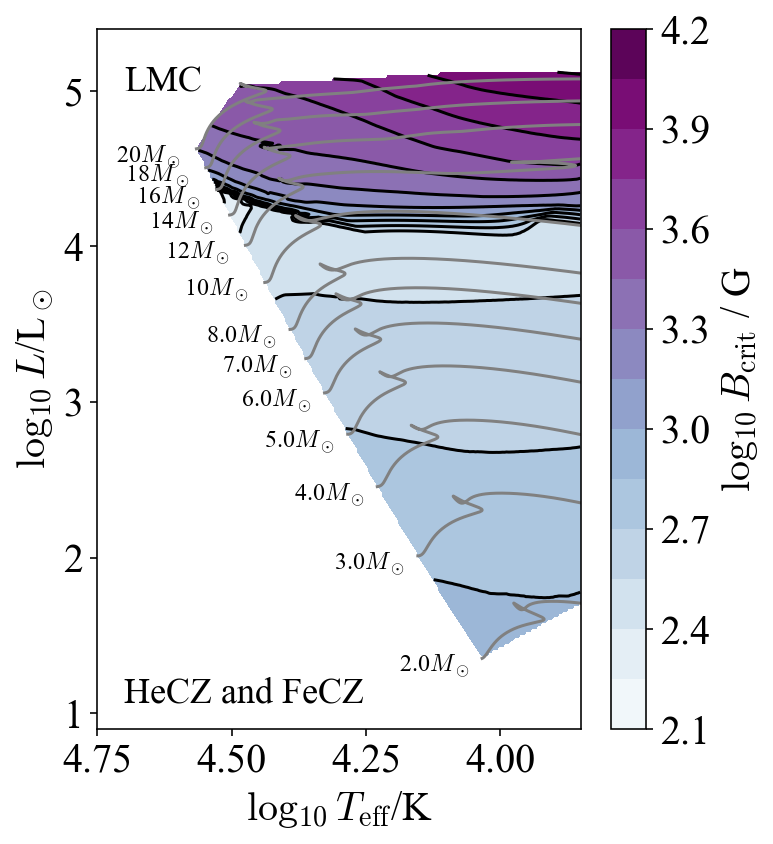

In [41]:
# Use ell_sun to make Spectroscopic HRD, if needed
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      HI_B_shutoff_conv = h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= h.FeCZ_B_shutoff_conv
    
      #max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,HI_B_shutoff_conv,FeCZ_B_shutoff_conv])
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,FeCZ_B_shutoff_conv])

      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_shutoff_conv[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)
    #z=((1/z)*1e6)/1.6 # in microHz (the 1.6 is to correct for alpha_mixing lenght, as I calculated turnover timescales as alpha*<Hp>/<vconv>

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    
    
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='BuPu',setlims=True) #cmap="YlOrRd") cmap='plasma'
    
    # fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\nu_{char}$ ($\mu$Hz)')
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.09
    dl = -0.09
    k=0
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=12) # ,verticalalignment='center',rotation='vertical',  
       # k=k+1    
    
  
    
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.text(4.7,1.07,'HeCZ and FeCZ',fontsize=18)
    ax.text(4.7,5,'LMC',fontsize=18)
    ax.set_xlim([4.75,3.85])
    ax.set_ylim([0.9,5.4])
    
   # plt.title(r'Subsurface Convection B$_{\rm Crit}$')
    plt.savefig(FIGURES+"B_shutoff_LMC.pdf",bbox_inches='tight')

read_models(DIR,mods)


### Surface Magnetic Fields

/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


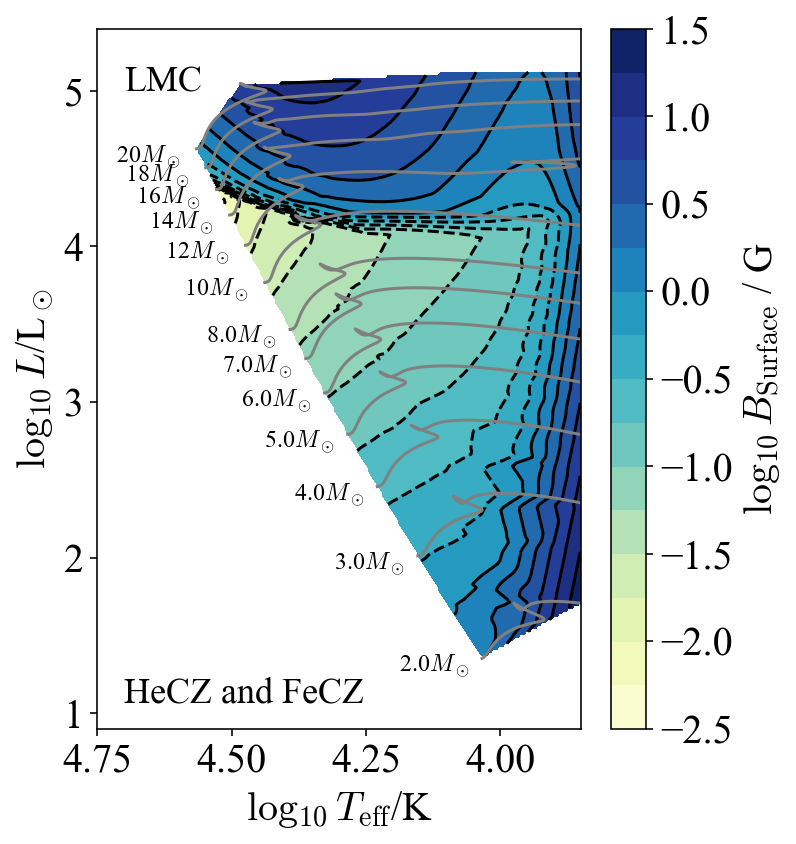

In [42]:
# Use ell_sun to make Spectroscopic HRD, if needed
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      b_FeCZ_surf     = h.b_FeCZ_surf
      b_FeCZ_surf_max = h.b_FeCZ_surf_max 
      b_HeII_surf     = h.b_HeII_surf
      b_HeII_surf_max = h.b_HeII_surf_max 
      b_HeI_surf      = h.b_HeI_surf
      b_HeI_surf_max  = h.b_HeI_surf_max 
    
      
      max_B_surf = np.maximum.reduce([b_FeCZ_surf,b_HeII_surf,b_HeI_surf])
      #max_B_surf_max = np.maximum.reduce([b_FeCZ_surf_max,b_HeII_surf_max,b_HeI_surf_max])
    
    
      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_surf[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)
    #z=((1/z)*1e6)/1.6 # in microHz (the 1.6 is to correct for alpha_mixing lenght, as I calculated turnover timescales as alpha*<Hp>/<vconv>

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlGnBu',setlims=True) #cmap="YlOrRd")
    # fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\nu_{char}$ ($\mu$Hz)')
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bsbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.09
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=12) # ,verticalalignment='center',rotation='vertical',  
    
    
    
     
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.text(4.7,1.07,'HeCZ and FeCZ',fontsize=18)
    ax.text(4.7,5,'LMC',fontsize=18)
    ax.set_xlim([4.75,3.85])
    ax.set_ylim([0.9,5.4])
    
#    plt.title(r'Subsurface Convection Max(B$_{\rm Surf})$')
    plt.savefig(FIGURES+"B_surface_LMC.pdf",bbox_inches='tight')

read_models(DIR,mods)


## SMC Metallicity Grid

In [44]:
# Not including SMC grid in the ZENODO repository. But you can rerun it using the inlists and the scripts provided
FIGURES='/Users/mcantiello/Dropbox (Personal)/work/MagneticInhibition/figures/'
DIR = '/Users/mcantiello/Dropbox (Personal)/work/red_noise/Z0.02_CORE_BSHUTOFF_SMC/'
mods = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5 ,5.0 ,5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 9.0, 10, 11 ,12 ,13, 14, 15 ,16,17,18, 18, 19, 20,21,22,25,28,30,40]
hrdlines = [2.0, 3.0,  4.0, 5.0 , 6.0, 7.0,  8.0, 10,12 ,14,16,18,20,25,30,40]

/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:283: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 1]*y +
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:284: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 2])


[2.1        2.25025334 2.40050667 2.55076001 2.70101334 2.85126668
 3.00152001 3.15177335 3.30202668 3.45228002 3.60253335 3.75278669
 3.90304002 4.05329336]


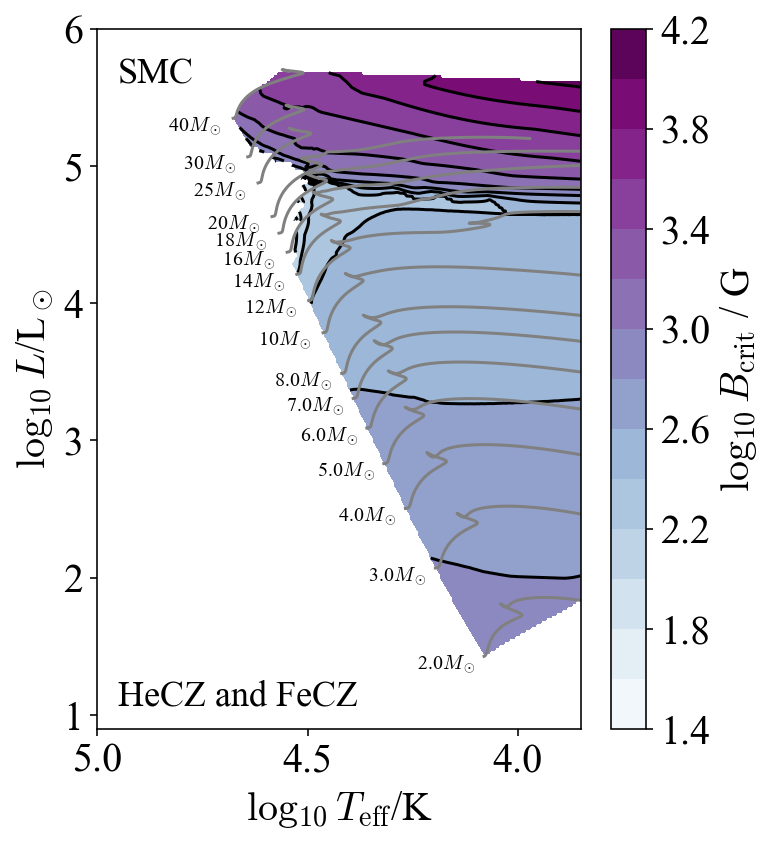

In [45]:
# Use ell_sun to make Spectroscopic HRD, if needed
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      HI_B_shutoff_conv = h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= h.FeCZ_B_shutoff_conv
    
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,HI_B_shutoff_conv,FeCZ_B_shutoff_conv])
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,FeCZ_B_shutoff_conv])

      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_shutoff_conv[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)
    #z=((1/z)*1e6)/1.6 # in microHz (the 1.6 is to correct for alpha_mixing lenght, as I calculated turnover timescales as alpha*<Hp>/<vconv>

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    vmin=2.1 # Set vmin for plot
    vmax=max(z)
    nlevels=14
    ax.contour(xi, yi, zi, nlevels, colors='k')
    
    
    cntr1 = ax.contourf(xi, yi, zi, nlevels, cmap='BuPu' ) #cmap="YlOrRd")cmap='viridis_r'
    
    # fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\nu_{char}$ ($\mu$Hz)')
    boundaries=np.linspace(vmin, vmax, nlevels)
    print(boundaries)
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.09
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=10) # ,verticalalignment='center',rotation='vertical',  
            
    
  
    
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.text(4.95,1.07,'HeCZ and FeCZ',fontsize=18)
    ax.text(4.95,5.6,'SMC',fontsize=18)
    ax.set_xlim([5.0,3.85])
    ax.set_ylim([0.9,6])
    
    
   # plt.title(r'Subsurface Convection B$_{\rm Crit}$')
    plt.savefig(FIGURES+"B_shutoff_SMC.pdf",bbox_inches='tight')

read_models(DIR,mods)


### Surface Magnetic Fields

/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:283: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 1]*y +
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:284: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 2])
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


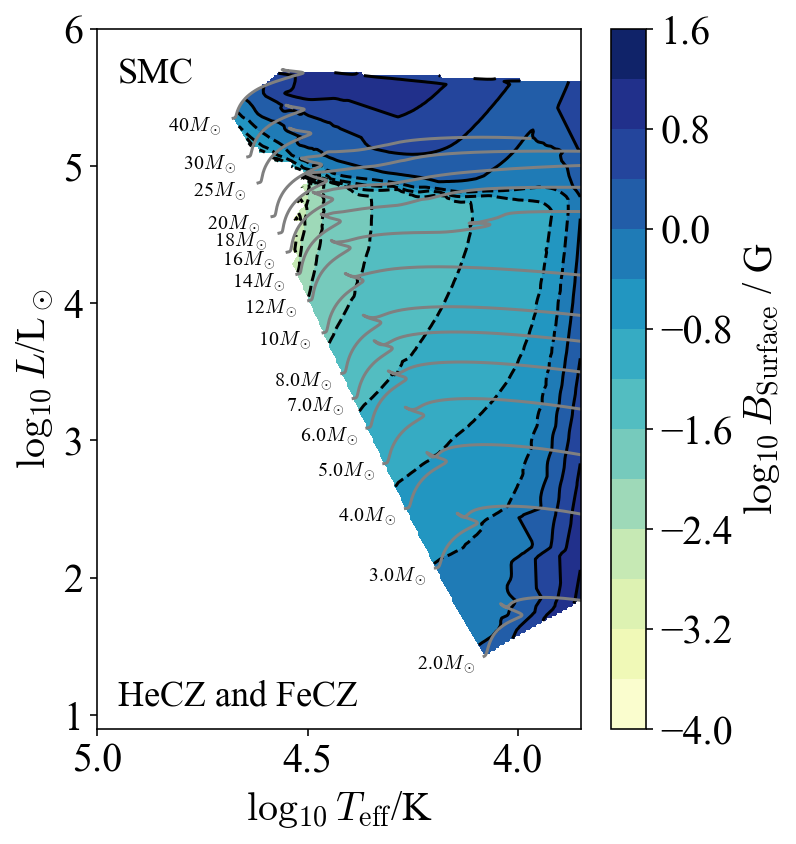

In [46]:
# Use ell_sun to make Spectroscopic HRD, if needed
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      b_FeCZ_surf     = h.b_FeCZ_surf
      b_FeCZ_surf_max = h.b_FeCZ_surf_max 
      b_HeII_surf     = h.b_HeII_surf
      b_HeII_surf_max = h.b_HeII_surf_max 
      b_HeI_surf      = h.b_HeI_surf
      b_HeI_surf_max  = h.b_HeI_surf_max 
    
      
      max_B_surf = np.maximum.reduce([b_FeCZ_surf,b_HeII_surf,b_HeI_surf])
      #max_B_surf_max = np.maximum.reduce([b_FeCZ_surf_max,b_HeII_surf_max,b_HeI_surf_max])
    
    
      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_surf[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)
    #z=((1/z)*1e6)/1.6 # in microHz (the 1.6 is to correct for alpha_mixing lenght, as I calculated turnover timescales as alpha*<Hp>/<vconv>

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlGnBu',setlims=True) #cmap="YlOrRd")
    # fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\nu_{char}$ ($\mu$Hz)')
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bsbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.09
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=10) # ,verticalalignment='center',rotation='vertical',  
    
    
    
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.text(4.95,1.07,'HeCZ and FeCZ',fontsize=18)
    ax.text(4.95,5.6,'SMC',fontsize=18)
    ax.set_xlim([5.0,3.85])
    ax.set_ylim([0.9,6])
    
    
#    plt.title(r'Subsurface Convection Max(B$_{\rm Surf})$')
    plt.savefig(FIGURES+"B_surface_SMC.pdf",bbox_inches='tight')

read_models(DIR,mods)


# Milky Way Grid Z = 0.014

In [47]:
# Not including MW grid in the ZENODO repository. But you can rerun it using the inlists and the scripts provided

FIGURES='/Users/mcantiello/Dropbox (Personal)/work/MagneticInhibition/figures/'
DIR = '/Users/mcantiello/Dropbox (Personal)/work/red_noise/Z0.014_CORE_BSHUTOFF/'
mods = [ 2.0, 2.2, 2.4,2.6, 2.8, 3.0,3.2, 3.4, 3.6 ,3.8, 4.0 ,4.2, 4.4 ,4.6 ,4.8 ,5.0, 5.2, 5.4 ,5.6 ,5.8, 6.0, 7.0,8.0,9.0,10,11,12,13]# ,12]#,13,14,15]
hrdlines = [2.0,2.4,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10,11,12,13] # ,12]#,15]# ,20,25,30,40,60,80,120]

/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:283: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 1]*y +
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:284: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 2])
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


2.4 M$_\odot$
3.9414023101459055
1.676670432408777


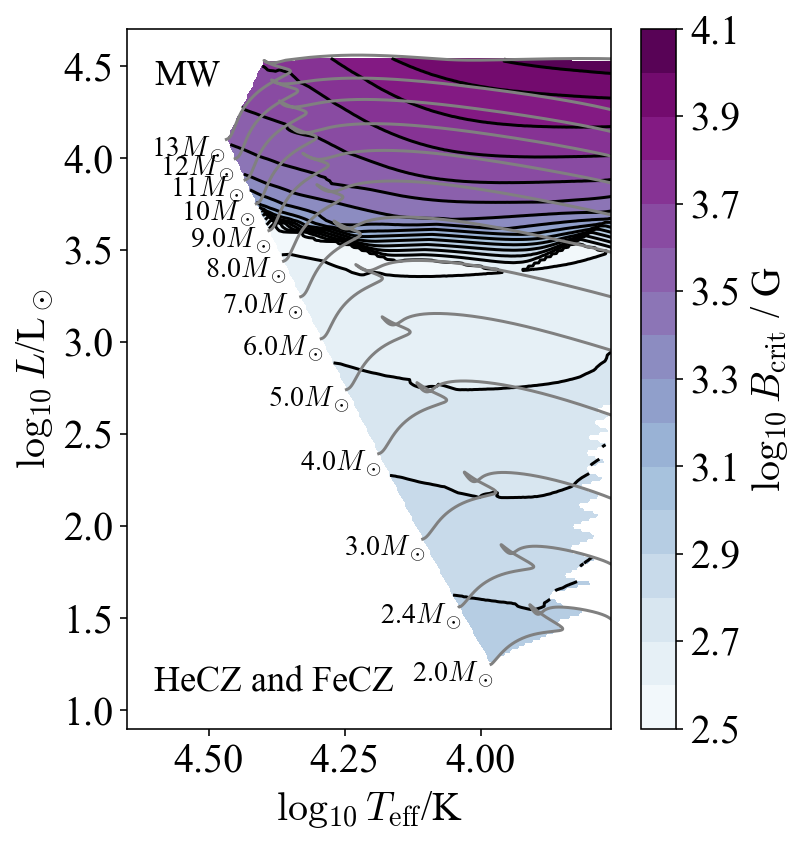

In [48]:
# Use ell_sun to make Spectroscopic HRD, if needed
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      HI_B_shutoff_conv = h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= h.FeCZ_B_shutoff_conv
    
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,HI_B_shutoff_conv,FeCZ_B_shutoff_conv])
      max_B_shutoff_conv = np.maximum.reduce([HeII_B_shutoff_conv,HeI_B_shutoff_conv,FeCZ_B_shutoff_conv])

      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_shutoff_conv[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)
    #z=((1/z)*1e6)/1.6 # in microHz (the 1.6 is to correct for alpha_mixing lenght, as I calculated turnover timescales as alpha*<Hp>/<vconv>

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    
    
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='BuPu' ,setlims=True) #cmap="YlOrRd")cmap='YlGnBu' cmap='plasma' cmap='BuPu'
    
    # fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\nu_{char}$ ($\mu$Hz)')
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.07
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=14) # ,verticalalignment='center',rotation='vertical',  
            
    
    # ADD LOCATION OF EXTRACTED PROFILES
    LOC=[(r'2.4 M$_\odot$',logt2,logl2,'v'),(r'5 M$_\odot$',logt5,logl5,'^'),(r'9 M$_\odot$',logt9,logl9,'o')] 
    COL=[RED_PURPLE,SKY_BLUE,BLUE_GREEN]
    COL=['salmon','darkgray','slateblue']
    COL=['tab:orange','tab:blue','lightsteelblue']
    COL=['#fbb4ae','#b3cde3','#ccebc5'] # Colorblind friendly https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
    COL=['#d73027','darkgray','#3288bd']
    print(LOC[0][0])
    print(LOC[0][1])
    print(LOC[0][2])
   # for i in range(len(LOC[0])-1):
        #print(i)
   #     ax.scatter(LOC[i][1],LOC[i][2],label=LOC[i][0],marker=LOC[i][3],s=130,edgecolors='white',lw=1.0,zorder=3,color=COL[i])#,mks=10)
   # legend = ax.legend(loc='lower left',fontsize=16,bbox_to_anchor=(0.02,0.13),markerscale=1.3)#,frameon = True)
    
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.text(4.6,1.11,'HeCZ and FeCZ',fontsize=18)
    ax.set_xlim([4.65,3.76])
    ax.set_ylim([0.9,4.7])
    ax.text(4.6,4.4,'MW',fontsize=18)
    
   # plt.title(r'Subsurface Convection B$_{\rm Crit}$')
    plt.savefig(FIGURES+"B_shutoff_MW.pdf",bbox_inches='tight')

read_models(DIR,mods)


/Users/mcantiello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: divide by zero encountered in log10
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:283: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 1]*y +
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/tri/triinterpolate.py:284: RuntimeWarning: invalid value encountered in add
  self._plane_coefficients[tri_index, 2])
/Users/mcantiello/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'setlims'
  s)


2.4 M$_\odot$
3.9414023101459055
1.676670432408777


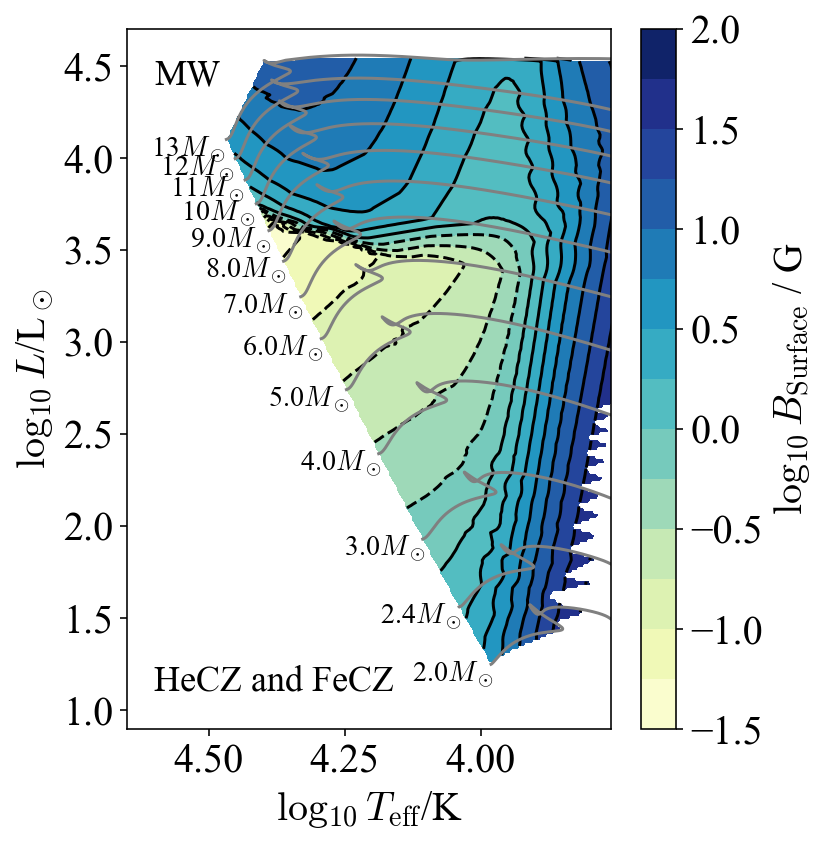

In [49]:
# Use ell_sun to make Spectroscopic HRD, if needed
ell_sun=(5777)**4.0/(274*100)  

def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0

    zhI = []
    zheI = []
    zheII = []
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      b_FeCZ_surf     = h.b_FeCZ_surf
      b_FeCZ_surf_max = h.b_FeCZ_surf_max 
      b_HeII_surf     = h.b_HeII_surf
      b_HeII_surf_max = h.b_HeII_surf_max 
      b_HeI_surf      = h.b_HeI_surf
      b_HeI_surf_max  = h.b_HeI_surf_max 
    
      
      max_B_surf = np.maximum.reduce([b_FeCZ_surf,b_HeII_surf,b_HeI_surf])
      #max_B_surf_max = np.maximum.reduce([b_FeCZ_surf_max,b_HeII_surf_max,b_HeI_surf_max])
    
    
      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
      
      ncz=h.subsurface_convective_regions 
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      lzams.append(logl[zams])
      gzams.append(logg[zams])
      tzams.append(logl[zams])
      x.append(logt[zams:])
      y.append(logl[zams:])
      #z.append(v_FeCZ_surf[zams:]) 
      z.append(max_B_surf[zams:])
      
    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))#/1e5 # (in km/s)
    #z=((1/z)*1e6)/1.6 # in microHz (the 1.6 is to correct for alpha_mixing lenght, as I calculated turnover timescales as alpha*<Hp>/<vconv>

    z=np.log10(z) 
    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlGnBu',setlims=True) #cmap="YlOrRd")
    # fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\nu_{char}$ ($\mu$Hz)')
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(bsbar)
    plt.gca().invert_xaxis()
    
   
    dt = 0.07
    dl = -0.09
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        loglh=h.log_LH 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_zams(logl,loglh,model)
        tams=find_tams(center_h1,model)
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        plt.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,logl[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=14) # ,verticalalignment='center',rotation='vertical',  
    
    
    
      # ADD LOCATION OF EXTRACTED PROFILES
    LOC=[(r'2.4 M$_\odot$',logt2,logl2,'v'),(r'5 M$_\odot$',logt5,logl5,'^'),(r'9 M$_\odot$',logt9,logl9,'o')] 
    COL=[RED_PURPLE,SKY_BLUE,BLUE_GREEN]
    COL=['salmon','darkgray','slateblue']
    COL=['tab:orange','tab:blue','lightsteelblue']
    COL=['#fbb4ae','#b3cde3','#ccebc5'] # Colorblind friendly https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
    COL=['#d73027','darkgray','#3288bd']
    print(LOC[0][0])
    print(LOC[0][1])
    print(LOC[0][2])
  #  for i in range(len(LOC[0])-1):
  #      ax.scatter(LOC[i][1],LOC[i][2],label=LOC[i][0],marker=LOC[i][3],s=130,edgecolors='white',lw=1.0,zorder=3,color=COL[i])#,mks=10)
  #  legend = ax.legend(loc='lower left',fontsize=16,bbox_to_anchor=(0.02,0.13),markerscale=1.3)#,frameon = True)
    
    
  

    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)
    
    ax.text(4.6,1.11,'HeCZ and FeCZ',fontsize=18)
    ax.set_xlim([4.65,3.76])
    ax.set_ylim([0.9,4.7])
    ax.text(4.6,4.4,'MW',fontsize=18)
    
    
#    plt.title(r'Subsurface Convection Max(B$_{\rm Surf})$')
    plt.savefig(FIGURES+"B_surface_MW.pdf",bbox_inches='tight')

read_models(DIR,mods)


## Calculate B$_{\rm Crit}$ (M) halfway throught the Main Sequence

- Load data, find mid_ms 
- Save M, B_crit (mid_ms)

In [55]:
DIR = './'
mods = [ 2.0, 2.2, 2.4,2.6, 2.8, 3.0,3.2, 3.4, 3.6 ,3.8, 4.0 ,4.2, 4.4 ,4.6 ,4.8 ,5.0, 5.2, 5.4 ,5.6 ,5.8, 6.0, 7.0,8.0,9.0,10,11,12]


In [56]:
# Find middle of main sequence (in age)
def find_mid_ms(model,star_age,zams,tams):
    mid_ms=1
    age_ms=(star_age[tams]-star_age[zams])/2
    while (star_age[mid_ms] < age_ms): 
     mid_ms=mid_ms+1
    return mid_ms;  
def find_frac_ms(model,star_age,zams,tams,frac):
    frac_ms=1
    age_frac_ms=(star_age[tams]-star_age[zams])*frac
    while ((star_age[frac_ms] - star_age[zams]) < age_frac_ms): 
     frac_ms=frac_ms+1
    return frac_ms;    

In [57]:
for i in mods:
      h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
      model = h.model_number 
      star_age= h.star_age
      logl = h.log_L
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      HI_B_shutoff_conv = h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= h.FeCZ_B_shutoff_conv
      max_B_shutoff_conv = np.maximum.reduce([HI_B_shutoff_conv,HeII_B_shutoff_conv,HeI_B_shutoff_conv,FeCZ_B_shutoff_conv])
      
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      mid_ms=find_mid_ms(model,star_age,zams,tams) 
      #print(star_age[zams],star_age[mid_ms],star_age[tams],(star_age[mid_ms]-(star_age[tams]-star_age[zams])/2)/star_age[mid_ms])
      # Line above shows ~1% error in determination of mid age with this method. Given our ability to determine age of stars (~10%) no need for interpolation IMO
      print(i,max_B_shutoff_conv[zams],max_B_shutoff_conv[mid_ms],max_B_shutoff_conv[tams])

2.0 971.0126429468788 1354.633020844144 14218.950562407563
2.2 915.5796021992315 869.7563611432514 10646.388213158
2.4 860.7085047436717 821.4400478136668 3032.232586321797
2.6 819.763558730899 779.2455126682496 1345.1821285156198
2.8 787.2264219752943 742.791972329427 701.2589520880942
3.0 749.6158079804754 711.0101911368132 665.224072730911
3.2 716.4983160458181 681.6508750346263 636.2477065746895
3.4 696.6540596392194 655.8489347819847 608.0667212954352
3.6 671.5792259104753 632.1925207311644 584.8116678199862
3.8 650.5937274056705 609.4312638726192 562.728620840611
4.0 626.4605495612724 591.6594112866386 542.6210009659188
4.2 610.9017744350389 573.0284477330059 525.1880004338636
4.4 596.5837587677299 556.4425753429059 508.606644520695
4.6 579.094509883054 540.7374406214435 493.4379071034638
4.8 561.4763890673936 527.1991090083111 479.71557225521843
5.0 546.1131857866915 514.0133426151202 467.75472410810113
5.2 536.2556071595657 501.11708255217576 455.8955302369457
5.4 528.214578115

## Extract B$_{\rm crit}$ at $\Delta$ t = 0.1 fractional age

In [58]:
frac=np.arange(0,1.0,0.1)
frac = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for i in mods:
      h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
      model = h.model_number 
      star_age= h.star_age
      logl = h.log_L
      loglh=h.log_LH 
      center_h1 = h.center_h1 
      HI_B_shutoff_conv = h.HI_B_shutoff_conv
      HeI_B_shutoff_conv = h.HeI_B_shutoff_conv
      HeII_B_shutoff_conv= h.HeII_B_shutoff_conv
      FeCZ_B_shutoff_conv= h.FeCZ_B_shutoff_conv
      max_B_shutoff_conv = np.maximum.reduce([HI_B_shutoff_conv,HeII_B_shutoff_conv,HeI_B_shutoff_conv,FeCZ_B_shutoff_conv])
      
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      mid_ms=find_mid_ms(model,star_age,zams,tams) 

      for fraction in frac:
         a=find_frac_ms(model,star_age,zams,tams,fraction)    
         print(i,fraction,max_B_shutoff_conv[a])
          

2.0 0.0 971.0126429468788
2.0 0.1 960.0199698434722
2.0 0.2 953.3055480279028
2.0 0.3 946.2947150902033
2.0 0.4 939.1010977727509
2.0 0.5 1354.633020844144
2.0 0.6 2968.445324738394
2.0 0.7 11600.673194181842
2.0 0.8 17634.501607609593
2.0 0.9 4157.130309216887
2.0 1.0 14218.950562407563
2.2 0.0 915.5796021992315
2.2 0.1 900.9674096363632
2.2 0.2 894.7145990698701
2.2 0.3 885.7651940341815
2.2 0.4 878.8682936750101
2.2 0.5 869.7563611432514
2.2 0.6 862.0042562863152
2.2 0.7 854.5580342854967
2.2 0.8 1964.786475410466
2.2 0.9 4016.2637133868916
2.2 1.0 10646.388213158
2.4 0.0 860.7085047436717
2.4 0.1 852.5583393133691
2.4 0.2 845.3871187224092
2.4 0.3 837.3170711377707
2.4 0.4 830.265229286821
2.4 0.5 821.4400478136668
2.4 0.6 812.8692148516193
2.4 0.7 803.5152678383137
2.4 0.8 797.1532937823879
2.4 0.9 1542.5462213205149
2.4 1.0 3032.232586321797
2.6 0.0 819.763558730899
2.6 0.1 811.1305624677474
2.6 0.2 804.0510816733508
2.6 0.3 796.3821227193488
2.6 0.4 788.369428812541
2.6 0.5 779.

## Show the effect of shutting off subsurface convection

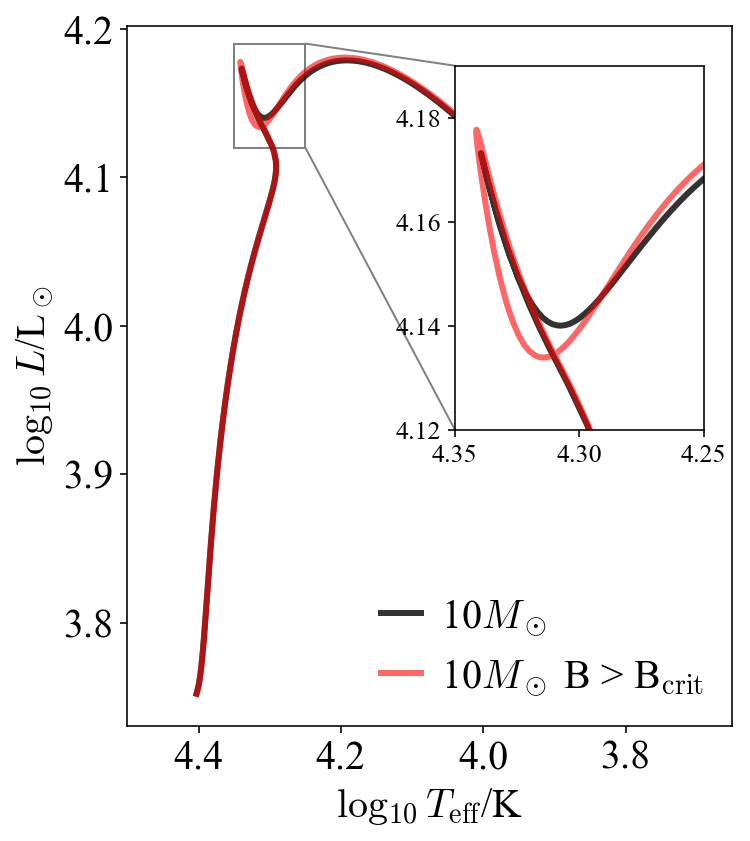

In [59]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

h=mr.MesaData(DIR+'10/LOGS/history.data')
model = h.model_number 
logl = h.log_L
loglh=h.log_LH 
center_h1 = h.center_h1 
logt= h.log_Teff 
zams=find_zams(logl,loglh,model)
tams=find_tams(center_h1,model)
zams=find_h(0.001,center_h1,model)

tm10=logt[zams:]
lm10=logl[zams:]

h=mr.MesaData(DIR+'10_SubsurfaceCZ/LOGS/history.data')
model = h.model_number 
logl = h.log_L
loglh=h.log_LH 
center_h1 = h.center_h1 
logt= h.log_Teff 
zams=find_zams(logl,loglh,model)
tams=find_tams(center_h1,model)
zams=find_h(0.001,center_h1,model)

tm10noscz=logt[zams:]
lm10noscz=logl[zams:]

fig = plt.figure()
ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
ax.plot(tm10,lm10,c='black',lw=3,alpha=0.8,label=r'10$M_\odot$')
ax.plot(tm10noscz,lm10noscz,c='red',lw=3,alpha=0.6,label=r'10$M_\odot$ B > B$_{\rm crit}$')

ax.set_xlabel(logteff)
ax.set_ylabel(logell)
 
ax.set_xlim([4.5,3.65])
#ax.set_ylim([0.9,4.7])

## ZOOM IN 
axins = zoomed_inset_axes(ax, 3.5, loc=1,bbox_to_anchor=(0.95,0.9),bbox_transform=ax.figure.transFigure) # zoom-factor: 2.5, location: upper-left
axins.plot(tm10,lm10,c='black',lw=3,alpha=0.8)
axins.plot(tm10noscz,lm10noscz,c='red',lw=3,alpha=0.6)


x1, x2, y1, y2 = 4.25, 4.35, 4.12, 4.19 # specify the limits
axins.set_xlim(x2, x1) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")
#plt.yticks(visible=False)
#plt.xticks(visible=False)
#axins.set_xticks([])
#axins.set_yticks([])
axins.tick_params(axis='both', which='major', labelsize=13)
axins.tick_params(axis='both', which='minor', labelsize=13)

legend = ax.legend(loc='lower right',fontsize=20,markerscale=1.3)#,frameon = True)    bbox_to_anchor=(0.02,0.13),
plt.savefig(FIGURES+"10_effects_CZ_inhibition.pdf",bbox_inches='tight')

            